# Centrality Dependence of nPDF Effects

## Setup, Import & Preprocess

In [1]:
# --------- publication styling toggles ----------
SAVE_PDF = True
SAVE_CSV = True
ADD_MINOR_TICKS = True

# subtle alpha for bands
ALPHA_BAND = 0.22

# note helpers
def put_note(ax, text, loc="lower right"):
    # uses your imported note_box if you like; otherwise a small text
    try:
        note_box(ax, text, loc=loc)
    except Exception:
        kw = dict(ha="right" if "right" in loc else "left",
                  va="bottom" if "upper" in loc else "bottom")
        xy = (0.98, 0.95) if "upper" in loc and "right" in loc else (0.02, 0.95)
        ax.text(*xy, text, transform=ax.transAxes, fontsize=10, alpha=0.9)

# Keep your colors mapping (already present) 
colors = {"5.02": "tab:blue", "8.16": "tab:red"}

def beautify_axis(ax, xlabel=None, ylabel=None, xlim=None, ylim=None):
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    if xlim:   ax.set_xlim(*xlim)
    if ylim:   ax.set_ylim(*ylim)
    # no grid; add minor ticks if requested
    if ADD_MINOR_TICKS:
        try:
            ax.xaxis.set_minor_locator(AutoMinorLocator())
            ax.yaxis.set_minor_locator(AutoMinorLocator())
        except Exception:
            pass
    ax.tick_params(which="both", direction="in")

In [2]:
# --- setup ---
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from pathlib import Path
sys.path.append("../npdf_code")

# ----------------------- imports -----------------------
from npdf_data   import NPDFSystem, RpAAnalysis, centers_to_left_edges
from npdf_data import step_band_xy, style_axes, note_box, step_band_from_left_edges
from gluon_ratio import EPPS21Ratio, GluonEPPSProvider
from glauber     import OpticalGlauber, SystemSpec

# ----------------------- user knobs -----------------------
P5_DIR   = "../input/npdf/pPb5TeV"
P8_DIR   = "../input/npdf/pPb8TeV"
EPPS_DIR = "../input/npdf/nPDFs"
OUTDIR   = Path("./output-npdf-comparisons"); OUTDIR.mkdir(exist_ok=True)

# energies & σ_NN (mb)
SQRTS   = { "5.02": 5023.0, "8.16": 8160.0 }
SIG_NN  = { "5.02": 67.0,   "8.16": 71.0 }
CENT_EDGES = [0,20,40,60,80,100]
# analysis windows (edit as needed)
Y_RANGES_THREE = [(-4.46,-2.96), (-1.37,0.43), (2.03,3.53)] 
PT_RANGE   = (0.0, 20.0)
PT_WINDOW = (1.5, 20)

# inelastic σ_NN (mb)
SIG_NN_MB = {"5.02": 67.2, "8.16": 71.0}

# centrality bins [%]
CENT_EDGES = [0,20,40,60,80,100]
cent_bins = [(0,20),(20,40),(40,60),(60,80),(80,100)]
Y_THREE = [(-4.46,-2.96), (-1.37,0.43), (2.03,3.53)]
# three y-windows (Backward, Mid, Forward)
Y_WINDOWS = [(-4.46,-2.96,"-4.46 < y < -2.96"), (-1.37,0.43,"-1.37 < y < 0.43"), (2.03,3.53,"2.03 < y < 3.53")]

# pT range to draw (for raw lines) and minimal pT accepted in averages
PT_RANGE  = (0.0, 20.0)
PT_FLOOR  = 1.8    # drop < 1.5 GeV from weighted averages (set 0.0 to disable)

# plotting
COL = {"5.02":"tab:blue", "8.16":"tab:red"}
LS  = {"5.02":"-", "8.16":"--"}
DPI = 150

plt.rcParams.update({"figure.dpi":DPI, "font.size":12})

# Build providers (use the same A and √sNN you’re analyzing) (gives 49 gluon S_AWS/S_A ratios)
epps5 = GluonEPPSProvider(EPPS21Ratio(A=208,  path="../input/npdf/nPDFs"),
                          sqrt_sNN_GeV=5023.0, m_state_GeV="charmonium",
                          y_sign_for_xA=-1)   # default: x_A ~ e^{-y}
epps8 = GluonEPPSProvider(EPPS21Ratio(A=208, path="../input/npdf/nPDFs"),
                          sqrt_sNN_GeV=8160.0, m_state_GeV="charmonium",
                          y_sign_for_xA=-1)

# Glauber systems (for centrality)
gl5 = OpticalGlauber(SystemSpec("pA", SQRTS["5.02"], A=208, sigma_nn_mb=SIG_NN["5.02"]))
gl8 = OpticalGlauber(SystemSpec("pA", SQRTS["8.16"], A=208, sigma_nn_mb=SIG_NN["8.16"]))

## Sigma_pA/sigma_pp (49 sets)
ana = RpAAnalysis()

sys5 = NPDFSystem.from_folder(P5_DIR, kick="pp", name="p+Pb 5.02 TeV")
r5   = ana.compute_rpa_grid(sys5.df_pp, sys5.df_pa, sys5.df_errors, pt_shift_min=0, shift_if_r_below=0.0, lowpt_policy="drop", join="intersect")
sys8 = NPDFSystem.from_folder(P8_DIR, kick="pp", name="p+Pb 8.16 TeV")
r8   = ana.compute_rpa_grid(sys8.df_pp, sys8.df_pa, sys8.df_errors, pt_shift_min=0, shift_if_r_below=0.0, lowpt_policy="drop", join="intersect")
systems = [("5.02", sys5, r5), ("8.16", sys8, r8)]

[Glauber] TA(r) LUT: A=208 d=0.549 r≤50 fm, dr=0.02, z≤50 fm
[Glauber] ∫T_A d^2x ≈ 208.483 (target A=208)
[Glauber] Tabulating T_AA(b), T_pA(b)…
[Glauber] σ_tot^AA ≈ 7718.37 mb, σ_tot^pA ≈ 1909.03 mb
[Glauber] TA(r) LUT: A=208 d=0.549 r≤50 fm, dr=0.02, z≤50 fm
[Glauber] ∫T_A d^2x ≈ 208.483 (target A=208)
[Glauber] Tabulating T_AA(b), T_pA(b)…
[Glauber] σ_tot^AA ≈ 7757.76 mb, σ_tot^pA ≈ 1925.90 mb


In [3]:
def mean_b_for_bin(glauber, c0, c1):
    # Use ᾱ(c0–c1) → invert to b̄ by shooting; or simply take the midpoint in b if you already tabulate.
    # Here we just take the mid-percentile in b (good, fast proxy).
    p_mid = 0.5 * (c0 + c1) / 100.0
    return glauber.b_from_percentile(p_mid, kind="pA")

b_avgs_5 = {f"{a}-{b}%": mean_b_for_bin(gl5, a, b) for (a,b) in cent_bins}
b_avgs_8 = {f"{a}-{b}%": mean_b_for_bin(gl8, a, b) for (a,b) in cent_bins}
print(b_avgs_5)
print(b_avgs_8)

{'0-20%': 2.4153245017802605, '20-40%': 4.219762074191607, '40-60%': 5.46238787090888, '60-80%': 6.4814819740443985, '80-100%': 7.522868495459839}
{'0-20%': 2.4260661113157966, '20-40%': 4.238492821559056, '40-60%': 5.486707787744164, '60-80%': 6.5088720266515985, '80-100%': 7.547943424943761}


## Raw Gluon Ratio $S_{AWS}/S_A$ and Cross sections ($\sigma_{pA}/\sigma_{pp}$) Results

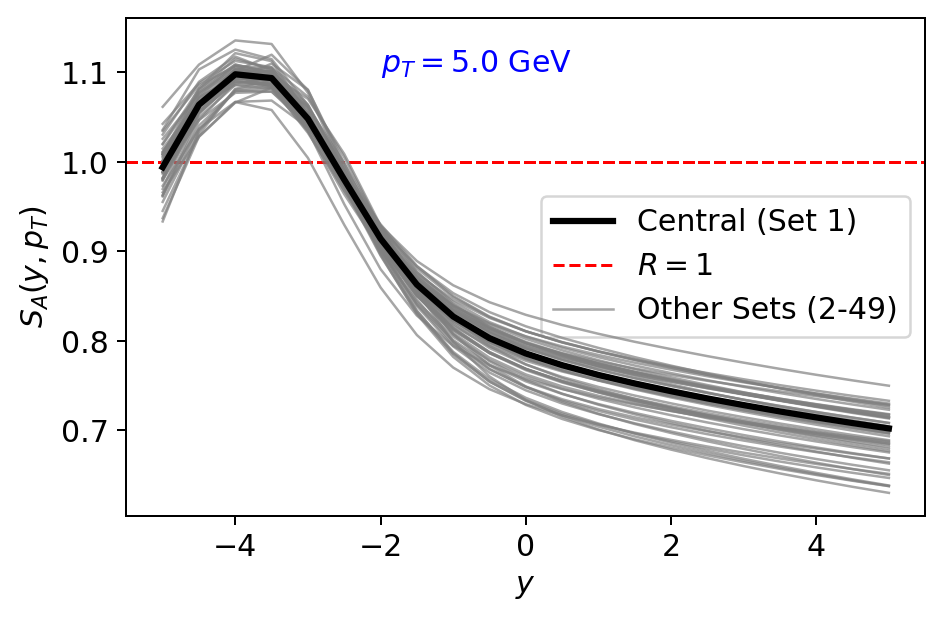

In [4]:
### Gluon Ratio S_A(y,pT)
# 1) Define variables
y = np.linspace(-5, 5, 21)
pt = 5.0

plt.figure(figsize=(5.4, 3.6), dpi=180)

# 4) Loop over all set_ids from 1 to 49
for i in range(1, 50):
    # Calculate SA for the current set_id
    SA = epps8.SA_ypt_set(y, np.full_like(y, pt), set_id=i)
    
    if i == 1:
        # Plot set 1 (Central) darker and thicker
        plt.plot(y, SA, lw=2.5, color='black', label="Central (Set 1)", zorder=50)
    else:
        # Plot other sets (2-49) lighter and thinner
        # Add a label only for the first "other" set (i=2) for the legend
        label = "Other Sets (2-49)" if i == 2 else None
        plt.plot(y, SA, lw=1, color='gray', alpha=0.7, label=label, zorder=10)
    plt.axhline(1.0, color='red', ls='--', lw=1.2, label=r"$R = 1$" if i == 1 else None)
# 5) Add labels and legend
plt.text(-2, 1.1, rf'$p_T = {pt}$ GeV', fontsize=12, color='blue')
plt.xlabel(r"$y$")
plt.ylabel(r"$S_{A}(y,p_T)$")
plt.legend(frameon=True)
plt.tight_layout()

In [5]:
# ## SAWS (B,Y,Pt)
# ## 8 TeV
# # 1) Define variables
# b_list  = np.linspace(0,10, 21)
# pT = 5.0
# y = -2.5

# plt.figure(figsize=(5.4, 3.6), dpi=180)

# # 4) Loop over all set_ids from 1 to 49
# for i in range(1, 50):
#     # Calculate SAWS for the current set_id=i
#     SAWS = np.array([epps8.SAWS_ypt_b_set(y, pT, b, set_id=i) for b in b_list])
    
#     if i == 1:
#         # Plot set 1 (Central) darker and thicker
#         plt.plot(b_list, SAWS, lw=2.5, color='black', label="Central (Set 1)", zorder=50)
#     else:
#         # Plot other sets (2-49) lighter and thinner
#         # Add a label only for the first "other" set (i=2) for the legend
#         label = "Other Sets (2-49)" if i == 2 else None
#         plt.plot(b_list, SAWS, lw=1, color='gray', alpha=0.7, label=label, zorder=10)
# # 5) Add labels and legend
# plt.text(6.5, 0.94, rf'$p_T = {pT}$ GeV', fontsize=12, color='blue')
# plt.xlabel(r"$b$ [fm]")
# plt.ylabel(r"$S_{AWS}(b,y,p_T)$")
# plt.legend(frameon=False)
# plt.tight_layout()

In [6]:
# # # S_AWS(b; y, pT) vs b at fixed y, pT ---hessian band----
# b_list  = np.linspace(0,10, 21)
# pT = 5.0
# y = -2.5
# SAWS_c = np.array([epps8.SAWS_ypt_b_set(y, pT, b, set_id=1) for b in b_list])
# band_list = [epps8.SAWS_band_ypt_b(y, pT, b, cl=68.0) for b in b_list]
# SAWS_lo, SAWS_hi = np.array(band_list).T
# plt.text(6, 0.75, rf'$p_T = {pT}$ GeV, y = {y}', fontsize=12, color='blue')
# plt.fill_between(b_list, SAWS_lo, SAWS_hi, alpha=0.25, label="EPPS21 Error Sets")
# plt.plot(b_list, SAWS_c, lw=2, label="Central")
# plt.xlabel(r"$b$"); plt.ylabel(r"$S_{A,\mathrm{WS}}(y,p_T;b)$"); plt.legend(frameon=False); plt.tight_layout()

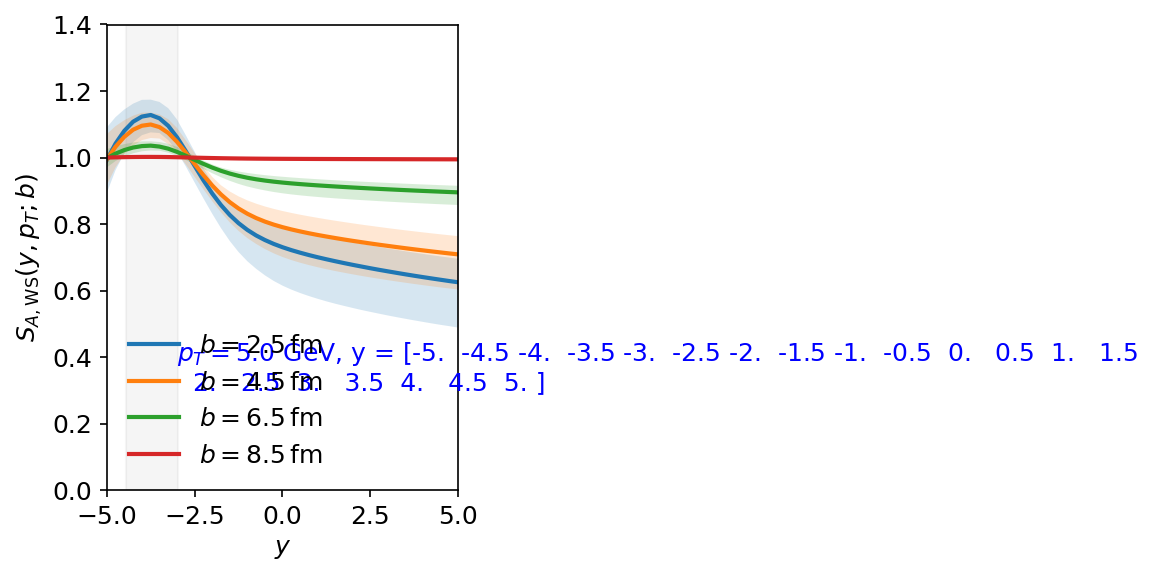

In [7]:
# --- S_AWS(b; y, pT) vs y at fixed b --- hessian band ---

pT_debug = 5.0   # or something like 1.5–2 GeV if you want closer to your averaging window
y_list   = np.linspace(-5.0, +5.0, 41)  # fine grid in backward/mid rapidity

# pick a few impact parameters to look at
b_vals = [2.5, 4.5, 6.5, 8.5]  # fm, just as an example

fig, ax = plt.subplots(figsize=(6,4))

for b in b_vals:
    SAWS_c  = np.array([epps8.SAWS_ypt_b_set(y, pT_debug, b, set_id=1) for y in y_list])
    band_xy = np.array([epps8.SAWS_band_ypt_b(y, pT_debug, b, cl=68.0) for y in y_list])
    SAWS_lo, SAWS_hi = band_xy.T

    ax.plot(y_list, SAWS_c, lw=2, label=rf"$b={b:.1f}\,\mathrm{{fm}}$")
    ax.fill_between(y_list, SAWS_lo, SAWS_hi, alpha=0.18)

# highlight your problematic backward bin ~[-4.46, -2.96]
ax.axvspan(-4.46, -2.96, alpha=0.08, color="grey")

ax.set_xlabel(r"$y$")
ax.set_ylabel(r"$S_{A,\mathrm{WS}}(y,p_T;b)$")
ax.legend(frameon=False)
ax.set_xlim(-5.0, +5)
ax.set_ylim(0.0, 1.4)
plt.text(-3,0.3, rf'$p_T = {pT_debug}$ GeV, y = {y}', fontsize=12, color='blue')
plt.tight_layout()
plt.show()

In [8]:
# ## KAWS (B,Y,Pt)
# ## 8 TeV
# # 1) Define variables
# b_list  = np.linspace(0,10, 21)
# pT = 5.0
# y = -2.5

# plt.figure(figsize=(5.4, 3.6), dpi=180)

# # 4) Loop over all set_ids from 1 to 49
# for i in range(1, 50):
#     # Calculate KAWS for the current set_id=i
#     KAWS = np.array([epps8.K_ypt_b_set(y, pT, b, set_id=i) for b in b_list])
    
#     if i == 1:
#         # Plot set 1 (Central) darker and thicker
#         plt.plot(b_list, KAWS, lw=2.5, color='black', label="Central (Set 1)", zorder=50)
#     else:
#         # Plot other sets (2-49) lighter and thinner
#         # Add a label only for the first "other" set (i=2) for the legend
#         label = "Other Sets (2-49)" if i == 2 else None
#         plt.plot(b_list, KAWS, lw=1, color='gray', alpha=0.7, label=label, zorder=10)
# # 5) Add labels and legend
# plt.text(2,1.03, rf'$p_T = {pT}$ GeV, y = {y}', fontsize=12, color='blue')
# plt.xlabel(r"$b$ [fm]")
# plt.ylabel(r"$K_{AWS}(b,y,p_T)$")
# plt.legend(frameon=False)
# plt.tight_layout()

In [9]:
# # --- S_AWS(b; y, pT) vs y at fixed b --- hessian band ---

# pT_debug = 0.25   # or something like 1.5–2 GeV if you want closer to your averaging window
# y_list   = np.linspace(-5.0, +5.0, 41)  # fine grid in backward/mid rapidity

# # pick a few impact parameters to look at
# b_vals = [2.5, 4.5, 6.5, 8.5]  # fm, just as an example

# fig, ax = plt.subplots(figsize=(6,4))

# for b in b_vals:
#     SAWS_c  = np.array([epps8.SAWS_ypt_b_set(y, pT_debug, b, set_id=1) for y in y_list])
#     band_xy = np.array([epps8.SAWS_band_ypt_b(y, pT_debug, b, cl=68.0) for y in y_list])
#     SAWS_lo, SAWS_hi = band_xy.T

#     ax.plot(y_list, SAWS_c, lw=2, label=rf"$b={b:.1f}\,\mathrm{{fm}}$")
#     ax.fill_between(y_list, SAWS_lo, SAWS_hi, alpha=0.18)

# # highlight your problematic backward bin ~[-4.46, -2.96]
# ax.axvspan(-4.46, -2.96, alpha=0.08, color="grey")

# ax.set_xlabel(r"$y$")
# ax.set_ylabel(r"$S_{A,\mathrm{WS}}(y,p_T;b)$")
# ax.legend(frameon=False)
# ax.set_xlim(-5.0, 1.0)
# ax.set_ylim(0.0, 1.6)
# plt.tight_layout()
# plt.show()

In [10]:
# # --- K_AWS(y; pT, b) for different b values (central bold, others faint) ---
# from matplotlib import colormaps
# y_list = np.linspace(-5.0, +5.0, 21)
# pT     = 5.0
# b_vals = [2.5, 4.5, 6.5, 8.5]

# # Give each b value a distinct color
# from matplotlib.cm import get_cmap
# cmap = colormaps["tab10"]
# colors_b = {b: cmap(i) for i, b in enumerate(b_vals)}

# plt.figure(figsize=(6.0, 4.2), dpi=180)

# for bi, b in enumerate(b_vals):

#     col = colors_b[b]

#     # --- loop over all 49 EPPS21 sets ---
#     for sid in range(1, 50):

#         # K_AWS(y,pT;b,set_id)
#         KAWS = np.array([epps8.K_ypt_b_set(y, pT, b, set_id=sid) for y in y_list])

#         if sid == 1:
#             # Central set = thick, dark
#             plt.plot(
#                 y_list, KAWS, lw=2.5, color=col,
#                 label=rf"$b={b:.1f}$ fm (central)", zorder=50
#             )
#         else:
#             # Error sets faint
#             # Give label only once (sid == 2)
#             lbl = "Hessian error sets" if (sid == 2 and bi == 0) else None

#             plt.plot(
#                 y_list, KAWS, lw=0.8, color=col, alpha=0.20,
#                 label=lbl, zorder=5
#             )

# # Axis decoration
# plt.xlabel(r"$y$")
# plt.ylabel(r"$K_{A,\mathrm{WS}}(y,p_T;b)$")
# plt.xlim(-5.0, +5.0)
# plt.ylim(0.0, 2.0)

# plt.legend(frameon=False, fontsize=9)
# plt.tight_layout()
# plt.show()

In [11]:
# # --- K_AWS(y; pT, b) for different b values (central bold, others faint) ---
# from matplotlib import colormaps
# y_list = np.linspace(-5.0, +5.0, 21)
# pT     = 5.0
# b_vals = [2.5, 4.5, 6.5, 8.5]

# # Give each b value a distinct color
# from matplotlib.cm import get_cmap
# cmap = colormaps["tab10"]
# colors_b = {b: cmap(i) for i, b in enumerate(b_vals)}

# plt.figure(figsize=(6.0, 4.2), dpi=180)

# for bi, b in enumerate(b_vals):

#     col = colors_b[b]

#     # --- loop over all 49 EPPS21 sets ---
#     for sid in range(1, 50):

#         # K_AWS(y,pT;b,set_id)
#         SAWS = np.array([epps8.SAWS_ypt_b_set(y, pT, b, set_id=sid) for y in y_list])
#         SA = np.array([epps8.SA_ypt_set(y, pT, set_id=sid) for y in y_list])
#         KAWS = SAWS / SA

#         if sid == 1:
#             # Central set = thick, dark
#             plt.plot(
#                 y_list, KAWS, lw=2.5, color=col,
#                 label=rf"$b={b:.1f}$ fm (central)", zorder=50
#             )
#         else:
#             # Error sets faint
#             # Give label only once (sid == 2)
#             lbl = "Hessian error sets" if (sid == 2 and bi == 0) else None

#             plt.plot(
#                 y_list, KAWS, lw=0.8, color=col, alpha=0.20,
#                 label=lbl, zorder=5
#             )

# # Axis decoration
# plt.xlabel(r"$y$")
# plt.ylabel(r"$K_{A,\mathrm{WS}}(y,p_T;b)$")
# plt.xlim(-5.0, +5.0)
# plt.ylim(0.0, 1.25)

# plt.legend(frameon=False, fontsize=9)
# plt.tight_layout()
# plt.show()

In [12]:
# # --- K_AWS(y; pT, b) for different b values (central bold, others faint) ---
# from matplotlib import colormaps
# y_list = np.linspace(-5.0, +5.0, 21)
# pT     = 5.0
# b_vals = [2.5, 4.5, 6.5, 8.5]

# # Give each b value a distinct color
# from matplotlib.cm import get_cmap
# cmap = colormaps["tab10"]
# colors_b = {b: cmap(i) for i, b in enumerate(b_vals)}

# plt.figure(figsize=(6.0, 4.2), dpi=180)

# for bi, b in enumerate(b_vals):

#     col = colors_b[b]

#     # --- loop over all 49 EPPS21 sets ---
#     for sid in range(1, 50):

#         # K_AWS(y,pT;b,set_id)
#         SAWS = np.array([epps8.SAWS_ypt_b_set(y, pT, b, set_id=sid) for y in y_list])
#         SA = epps8.SA_ypt_set(y, np.full_like(y, pT), set_id=sid)
#         KAWS = SAWS / SA

#         if sid == 1:
#             # Central set = thick, dark
#             plt.plot(
#                 y_list, KAWS, lw=2.5, color=col,
#                 label=rf"$b={b:.1f}$ fm (central)", zorder=50
#             )
#         else:
#             # Error sets faint
#             # Give label only once (sid == 2)
#             lbl = "Hessian error sets" if (sid == 2 and bi == 0) else None

#             plt.plot(
#                 y_list, KAWS, lw=0.8, color=col, alpha=0.20,
#                 label=lbl, zorder=5
#             )

# # Axis decoration
# plt.xlabel(r"$y$")
# plt.ylabel(r"$K_{A,\mathrm{WS}}(y,p_T;b)$")
# plt.xlim(-5.0, +5.0)
# plt.ylim(0.0, 1.25)

# plt.legend(frameon=False, fontsize=9)
# plt.tight_layout()
# plt.show()

In [13]:
# --- helpers: raw per-member R_pA lines with faded error sets (NO bands) ---
def _plot_raw_members_vs_y(ax, sysX, pt_min, color, central_label, weight_mode="pa"):
    # common grid & members
    base, r0, M = ana.compute_rpa_members(sysX.df_pp, sysX.df_pa, sysX.df_errors, join="intersect", lowpt_policy="drop", pt_shift_min=0, shift_if_r_below=0.0)

    # weights aligned to base
    rgrid_min = base.copy()
    rgrid_min["r_central"] = r0
    wtab = RpAAnalysis._make_weight_table(rgrid_min, sysX.df_pa, df_pp=sysX.df_pp, mode=weight_mode)
    wfull = wtab["w"].to_numpy()

    yvals = np.sort(base["y"].unique())
    yb = base["y"].to_numpy()
    pb = base["pt"].to_numpy()

    # ---- central line
    ys_c, Rs_c = [], []
    for yy in yvals:
        m = (yb == yy) & (pb >= float(pt_min))
        if not np.any(m): 
            continue
        R = r0[m]
        w = wfull[m]
        g = (w > 0) & np.isfinite(R)
        if np.any(g):
            ys_c.append(float(yy))
            Rs_c.append(float(np.sum(R[g]*w[g]) / np.sum(w[g])))
    if len(ys_c) >= 2:
        ax.plot(ys_c, Rs_c, "-", linewidth=2.0, color=color, label=central_label, zorder=5)

    # ---- error-member lines (faded)
    if M.size:
        for j in range(M.shape[0]):
            ys_j, Rs_j = [], []
            for yy in yvals:
                m = (yb == yy) & (pb >= float(pt_min))
                if not np.any(m):
                    continue
                Rj = M[j, m]
                w  = wfull[m]
                g = (w > 0) & np.isfinite(Rj)
                if np.any(g):
                    ys_j.append(float(yy))
                    Rs_j.append(float(np.sum(Rj[g]*w[g]) / np.sum(w[g])))
            if len(ys_j) >= 2:
                ax.plot(ys_j, Rs_j, "-", linewidth=0.8, alpha=0.18, color=color, zorder=3)

def _plot_raw_members_vs_pt(ax, sysX, y_min, y_max, color, central_label, weight_mode="pa"):
    # common grid & members (aligned base order)
    base, r0, M = ana.compute_rpa_members(sysX.df_pp, sysX.df_pa, sysX.df_errors, join="intersect",pt_shift_min=0, shift_if_r_below=0.0)

    rgrid_min = base.copy()
    rgrid_min["r_central"] = r0
    wtab = RpAAnalysis._make_weight_table(rgrid_min, sysX.df_pa, df_pp=sysX.df_pp, mode=weight_mode)
    w_full = base.merge(wtab, on=["y","pt"], how="left")["w"].to_numpy()

    yb = base["y"].to_numpy(); pb = base["pt"].to_numpy()
    mY = (yb >= float(y_min)) & (yb <= float(y_max))
    pts = np.sort(np.unique(pb[mY]))

    # central line
    Rc = []
    for p in pts:
        m = mY & (pb == p)
        if not np.any(m):
            Rc.append(np.nan); continue
        R = r0[m]; w = w_full[m]
        g = (w > 0) & np.isfinite(R)
        Rc.append(float(np.sum(R[g]*w[g]) / np.sum(w[g])) if np.any(g) else np.nan)
    ax.plot(pts, Rc, "-", linewidth=2.0, color=color, label=central_label, zorder=5)

    # members → individual thin lines (faded)
    if M.size:
        for j in range(M.shape[0]):
            Rj_all = []
            for p in pts:
                m = mY & (pb == p)
                if not np.any(m):
                    Rj_all.append(np.nan); continue
                Rj = M[j, m]; w = w_full[m]
                g = (w > 0) & np.isfinite(Rj)
                Rj_all.append(float(np.sum(Rj[g]*w[g]) / np.sum(w[g])) if np.any(g) else np.nan)
            ax.plot(pts, np.asarray(Rj_all, float), "-", linewidth=0.8, alpha=0.18, color=color, zorder=3)


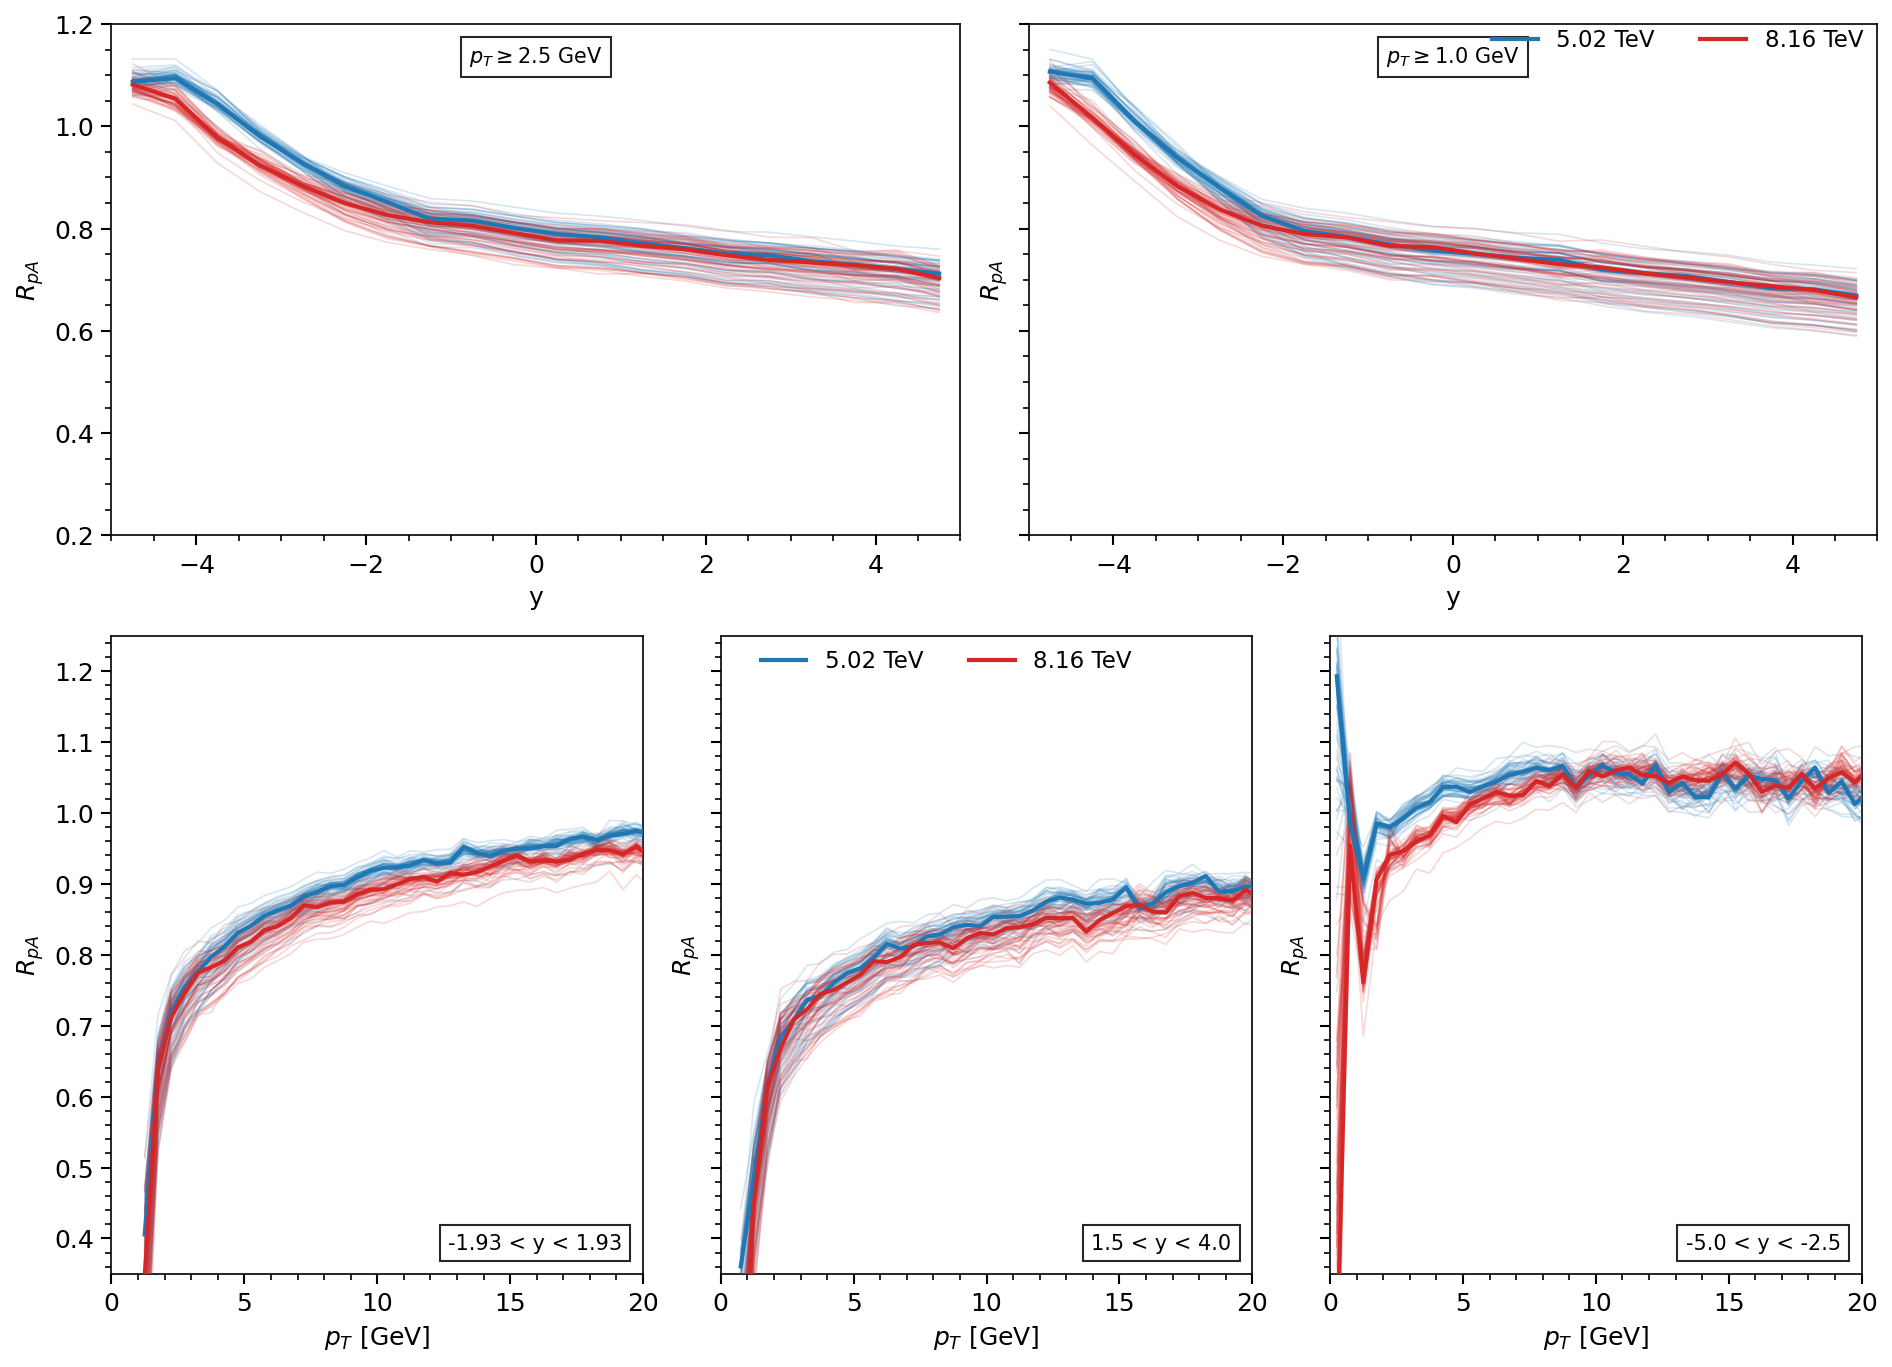

In [14]:
# ===== EXTRA FIGURE (LINES): raw R_pA_mb_k vs y (top: pT thresholds) and vs pT (bottom: y-windows) =====
fig2 = plt.figure(figsize=(12.5, 9.0), constrained_layout=True)
sft2, sfb2 = fig2.subfigures(2, 1, height_ratios=[1.0, 1.2])

# --- TOP: vs y at two pT thresholds ---
axes2_y = sft2.subplots(1, 2, sharey=True)
for ax, (ptmin, note) in zip(
    axes2_y,
    [(2.5, r"$p_T \geq 2.5$ GeV"), (1.0, r"$p_T \geq 1.0$ GeV")]
):
    _plot_raw_members_vs_y(ax, sys5, ptmin, colors["5.02"], "5.02 TeV")
    _plot_raw_members_vs_y(ax, sys8, ptmin, colors["8.16"], "8.16 TeV")
    style_axes(ax, "y", r"$R_{pA}$", grid=False)
    ax.set_xlim(-5.0, 5.0)
    ax.set_ylim(0.2, 1.2)
    note_box(ax, note, loc="upper center")
# single legend for top
h2t, l2t = axes2_y[0].get_legend_handles_labels()
sft2.legend(h2t, l2t, loc="upper right", frameon=False, ncol=2, fontsize=11)

# --- BOTTOM: vs pT in three y-windows (all member lines) ---
y_windows = [(-1.93, 1.93, "-1.93 < y < 1.93"),
             ( 1.5 , 4.0 , "1.5 < y < 4.0"),
             (-5.0 , -2.5, "-5.0 < y < -2.5")]

axes2_pt = sfb2.subplots(1, len(y_windows), sharex=True, sharey=True)
if len(y_windows) == 1:
    axes2_pt = [axes2_pt]

for ax, (ymin, ymax, name) in zip(axes2_pt, y_windows):
    _plot_raw_members_vs_pt(ax, sys5, ymin, ymax, colors["5.02"], "5.02 TeV")
    _plot_raw_members_vs_pt(ax, sys8, ymin, ymax, colors["8.16"], "8.16 TeV")
    style_axes(ax, r"$p_T$ [GeV]", r"$R_{pA}$", grid=False)
    ax.set_xlim(0, 20)
    ax.set_ylim(0.35, 1.25)
    note_box(ax, fr"{name}", loc="lower right")
# single legend for bottom
h2b, l2b = axes2_pt[0].get_legend_handles_labels()
sfb2.legend(h2b, l2b, loc="upper center", frameon=False, ncol=2, fontsize=11)

fig2.savefig(f"{OUTDIR}/rpa_raw_members_vs_y_ptpanels.pdf", bbox_inches="tight")
plt.show()

## $R_{pA}(b,y,p_T)$ with Binned & Hessian Band

In [15]:
# --- BINNING WEIGHTS: choose one of: "pa@y0", "pa@local", "pp@local", "SA@y0", "flat"
WEIGHT_MODE   = "pp@local"   # your most stable choice
Y_REF         = 0.0       # used for *@y0 modes
CENT_EXP_C0 = 0.25  # c0 in w(c) = exp(-c/c0) / ∫_0^1 exp(-u/c0) du
# --- σ-weight truncation in low pT (acts on the WEIGHTS only, not on R itself)
PT_FLOOR_W    = 1.5       # for pT < PT_FLOOR_W, replace weight by weight at first pT ≥ PT_FLOOR_W (same y-slab)

# --- Range knobs
PT_RANGE_AVG  = (1.5, 15.0)    # pT range used in R(y) binning
Y_WINDOWS     = [(-4.46,-2.96,"Backward"), (-1.37,0.43,"Mid"), (2.03,3.53,"Forward")]
P_EDGES       = np.arange(0.0, 15.0+2.5, 2.5)
Y_EDGES       = np.arange(-5.0, 5.0+0.25, 0.5)

COLORS = {"5.02":"tab:blue", "8.16":"tab:red"}
LSTYLE = {"5.02":"-",        "8.16":"--"}

In [16]:
# --- σ-members on the common grid (pairwise Hessian order preserved)
ana = RpAAnalysis()

# small low-pT hardening *on R itself* (optional). If you want raw σ-ratio, keep "drop"/pt_shift_min=0.
base5, r0_5, M5 = ana.compute_rpa_members(sys5.df_pp, sys5.df_pa, sys5.df_errors,
                                          join="intersect", lowpt_policy="drop",
                                          pt_shift_min=PT_FLOOR_W, shift_if_r_below=0.0)
base8, r0_8, M8 = ana.compute_rpa_members(sys8.df_pp, sys8.df_pa, sys8.df_errors,
                                          join="intersect", lowpt_policy="drop",
                                          pt_shift_min=PT_FLOOR_W, shift_if_r_below=0.0)

In [48]:
# --- Build K(b) central + members by looping set_id (guaranteed alignment 2..49)
# def K0_KM_from_provider(gluon, base_df, b_val):
#     yy = base_df["y"].to_numpy()
#     pp = base_df["pt"].to_numpy()

#     # central
#     SA0   = gluon.SA_ypt_set(yy, pp, set_id=1)
#     SAWS0 = gluon.SAWS_ypt_b_set(yy, pp, b_val, set_id=1)
#     K0    = SAWS0 / np.clip(SA0, 1e-12, None)                     # (N,)

#     # members 2..49
#     KM = []
#     for sid in range(2, 50):
#         SAm   = gluon.SA_ypt_set(yy, pp, set_id=sid)
#         SAWSm = gluon.SAWS_ypt_b_set(yy, pp, b_val, set_id=sid)
#         KM.append(SAWSm / np.clip(SAm, 1e-12, None))
#     KM = np.stack(KM, axis=0)                                      # (48, N)
#     return K0, KM

# --- Shadowing y-shift knob (Ramona’s suggestion) ---
# Fraction of the y-bin width to shift S_A(y,pT) when building K(b).
# 0.0 → no shift (original behaviour, but with bug fixed below).
# 0.25 or 0.5 → Ramona’s suggested tests.
SHADOW_SHIFT_FRAC = 0.25   # you can experiment with 0.0, 0.25, 0.5

# Apply the shift only in backward rapidity (where the problem shows up)?
# If True: only y < 0 are shifted towards midrapidity.
# If False: all y-bins are shifted by the same amount.
SHADOW_BACKWARD_ONLY = True

def K0_KM_from_provider(gluon, base_df, b_val):
    """
    Build K(b;y,pT) = S_AWS/S_A for the central EPPS21 set (1) and
    all 48 error members (2..49), on the SAME (y, pT) grid as base_df,
    with an optional Ramona-style y shift applied consistently.

    Parameters
    ----------
    gluon   : GluonEPPSProvider instance (epps5 or epps8).
    base_df : DataFrame with columns ['y','pt'] defining the grid.
    b_val   : impact parameter value (in fm) at which to evaluate K.
    """

    yy = base_df["y"].to_numpy().astype(float)
    pp = base_df["pt"].to_numpy().astype(float)

    # --- infer an effective Δy from the grid itself ---
    y_unique = np.unique(np.round(yy, 6))
    if y_unique.size > 1:
        dy_bin = float(np.median(np.diff(np.sort(y_unique))))
    else:
        dy_bin = 0.0

    # --- Ramona-style y shift: δy = f * Δy_bin ---
    if SHADOW_SHIFT_FRAC and dy_bin > 0.0:
        delta_y = SHADOW_SHIFT_FRAC * dy_bin
        if SHADOW_BACKWARD_ONLY:
            # shift only backward-y bins toward midrapidity
            y_eff = yy + np.where(yy < 0.0, delta_y, 0.0)
        else:
            # uniform shift of all bins
            y_eff = yy + delta_y
    else:
        # no shift
        y_eff = yy

    # --- central set (id=1), evaluated at y_eff ---
    SA0   = gluon.SA_ypt_set(y_eff, pp, set_id=1)
    SAWS0 = gluon.SAWS_ypt_b_set(y_eff, pp, b_val, set_id=1)
    K0    = SAWS0 / np.clip(SA0, 1e-12, None)   # shape (N,)

    # --- error members 2..49, ALSO at y_eff ---
    KM_list = []
    for sid in range(2, 50):
        SAm   = gluon.SA_ypt_set(y_eff, pp, set_id=sid)
        SAWSm = gluon.SAWS_ypt_b_set(y_eff, pp, b_val, set_id=sid)
        KM_list.append(SAWSm / np.clip(SAm, 1e-12, None))

    KM = np.stack(KM_list, axis=0)             # shape (48, N)
    return K0, KM


def K0_KM_avg_over_bin(gluon, base_df, glauber, c0, c1, nb=21):
    ps = np.linspace(c0/100.0, c1/100.0, nb)
    bgrid = np.array([glauber.b_from_percentile(p, kind="pA") for p in ps])
    K0s, KMs = [], []
    for b in bgrid:
        K0, KM = K0_KM_from_provider(gluon, base_df, b)  # your existing helper
        K0s.append(K0); KMs.append(KM)
    K0 = np.average(np.stack(K0s, axis=0), axis=0)
    KM = np.average(np.stack(KMs, axis=0), axis=0)
    return K0, KM

# --- Fuse σ and K(b) ⇒ 49 sets per centrality, per energy
def fuse_sigma_and_K(base_df, r0, M, K0, KM):
    r0b = r0 * K0                        # central: (N,) elementwise
    Mb  = M  * KM                        # members: (48,N) * (48,N) elementwise
    D   = Mb[0::2,:] - Mb[1::2,:]
    h   = 0.5*np.sqrt(np.sum(D*D, axis=0))
    out = base_df[["y","pt"]].copy()
    out["r_central"] = r0b
    out["r_lo"]      = r0b - h
    out["r_hi"]      = r0b + h
    # keep all 48 member columns for downstream “bin then Hessian”
    for j in range(Mb.shape[0]):
        out[f"r_mem_{j+1:03d}"] = Mb[j]
    return out

def hess_width_from_members(mem_vec_48):
    D = mem_vec_48[0::2] - mem_vec_48[1::2]
    return 0.5 * np.sqrt(np.sum(D*D))

In [49]:
# Glauber ⟨b⟩ for each centrality tag
cent_bins = [(0,20),(20,40),(40,60),(60,80),(80,100)]
# cent_bins = [(40,60),(60,80),(80,100)]
b_avgs_5  = {f"{a}-{b}%": mean_b_for_bin(gl5, a, b) for (a,b) in cent_bins}
b_avgs_8  = {f"{a}-{b}%": mean_b_for_bin(gl8, a, b) for (a,b) in cent_bins}

# Make the per-centrality 49-set tables
df49_by_cent_5, df49_by_cent_8 = {}, {}

for tag, b in b_avgs_5.items():
    K0, KM = K0_KM_from_provider(epps5, base5, b)
    df49_by_cent_5[tag] = fuse_sigma_and_K(base5, r0_5, M5, K0, KM)

for tag, b in b_avgs_8.items():
    K0, KM = K0_KM_from_provider(epps8, base8, b)
    df49_by_cent_8[tag] = fuse_sigma_and_K(base8, r0_8, M8, K0, KM)

In [50]:
## Centrality Weights
def make_centrality_weight_dict(cent_bins, c0=CENT_EXP_C0):
    """
    Return dict[tag] -> W_bin for each centrality bin, with tags like "0-20%".
    Uses your w(c) ∝ exp(-c/c0) on c∈[0,1], integrated over each bin.
    """
    # edges as fractions in [0,1]
    edges_frac = np.array(
        [cent_bins[0][0]] + [b for (_, b) in cent_bins],
        float
    ) / 100.0  # e.g. [0.0,0.2,0.4,0.6,0.8,1.0]

    # numerator: ∫_{c_min}^{c_max} exp(-c/c0) dc = c0 (e^{-c_min/c0} - e^{-c_max/c0})
    num   = np.exp(-edges_frac[:-1] / c0) - np.exp(-edges_frac[1:] / c0)
    denom = 1.0 - np.exp(-1.0 / c0)  # from ∫_0^1 exp(-u/c0) du = c0(1 - e^{-1/c0})
    w = num / max(denom, 1e-30)

    # safety re-normalization
    w = np.clip(w, 0.0, None)
    s = np.sum(w)
    if s > 0.0:
        w /= s
    else:
        w = np.ones_like(w) / len(w)

    tags = [f"{int(a)}-{int(b)}%" for (a, b) in cent_bins]
    return {tag: float(wi) for tag, wi in zip(tags, w)}

In [51]:
# centrality weights for all later MB constructions
WCENT = make_centrality_weight_dict(cent_bins)
print("centrality weights (w(c) scheme):", WCENT)

centrality weights (w(c) scheme): {'0-20%': 0.5609451038411363, '20-40%': 0.25204888243556506, '40-60%': 0.11325286325167577, '60-80%': 0.050887791728184854, '80-100%': 0.022865358743438213}


In [52]:
## Weights for y and pT binning (no y_guard_max, no winsor)
def _get_weights(sub, sysX, etag, mode=WEIGHT_MODE, *, y_ref=Y_REF, pt_floor_w=PT_FLOOR_W):
    """
    Returns normalized weights wn for the given sub-DF.

    Parameters
    ----------
    sub   : DataFrame slice in a (y, pT) bin; must contain columns 'y', 'pt',
            'r_central', and optional 'wcent'.
    sysX  : object with df_pp, df_pa (and df_errors elsewhere).
    etag  : "5.02" or "8.16" (to pick the gluon provider for SA@y0).
    mode  : "flat", "pa@y0", "pa@local", "pp@local", or "SA@y0".
    y_ref : reference y for *@y0 modes.
    pt_floor_w : if not None and mode uses σ-weights, for pT < pt_floor_w the
                 weight is replaced by the weight at the first pT ≥ pt_floor_w
                 at the same y.
    """

    # --- base weights ---
    if mode == "flat":
        w = np.ones(len(sub), float)

    # σ_pA(y_ref, pt) as function of pt only
    elif mode == "pa@y0":
        lut = {}
        for ptv, grp in sysX.df_pa.groupby("pt"):
            ys   = grp["y"].to_numpy()
            vals = grp["val"].to_numpy()
            j    = int(np.argmin(np.abs(ys - y_ref)))
            lut[float(ptv)] = float(vals[j])
        w = sub["pt"].map(lambda v: lut.get(float(v), 0.0)).to_numpy()

    # σ_pA(y, pt) at each local point
    elif mode == "pa@local":
        lut = {(float(r.y), float(r.pt)): float(r.val) for r in sysX.df_pa.itertuples()}
        w = np.array([lut.get((float(r.y), float(r.pt)), 0.0)
                      for r in sub.itertuples()], float)

    # σ_pp(y, pt) at each local point
    elif mode == "pp@local":
        lut = {(float(r.y), float(r.pt)): float(r.val) for r in sysX.df_pp.itertuples()}
        w = np.array([lut.get((float(r.y), float(r.pt)), 0.0)
                      for r in sub.itertuples()], float)

    # nPDF-only weight S_A(y_ref, pt)
    elif mode == "SA@y0":
        gprov = epps5 if etag == "5.02" else epps8
        puniq = np.sort(sub["pt"].unique())
        SAref = gprov.SA_ypt_set(np.full_like(puniq, y_ref), puniq, set_id=1)
        lut   = {float(p): float(v) for p, v in zip(puniq, SAref)}
        w = sub["pt"].map(lambda v: lut.get(float(v), 0.0)).to_numpy()

    else:
        raise ValueError(f"Unknown WEIGHT_MODE={mode}")

    # --- include centrality fraction if present (MB stacks) ---
    if "wcent" in sub.columns:
        w = w * sub["wcent"].to_numpy()

    # --- low-pT truncation (not for flat/SA), now without y_guard_max ---
    if (pt_floor_w is not None) and (mode not in ("flat", "SA@y0")) and len(sub):
        pt_arr = sub["pt"].to_numpy()
        mask_bad = (pt_arr < float(pt_floor_w))
        if np.any(mask_bad):
            src = sysX.df_pa if mode.startswith("pa@") else sysX.df_pp
            for yy in np.unique(sub.loc[mask_bad, "y"].to_numpy()):
                cand = src[(src["y"] == float(yy)) &
                           (src["pt"] >= float(pt_floor_w))].sort_values("pt")
                if len(cand):
                    w[(sub["y"].to_numpy() == yy) & mask_bad] = float(cand["val"].iloc[0])

    # --- normalize ---
    wsum = np.sum(w)
    if wsum > 0.0:
        wn = w / wsum
    else:
        wn = np.ones_like(w) / max(len(w), 1)

    return wn

# ## Weights for y and pT binning
# def _get_weights(sub, sysX, etag, mode=WEIGHT_MODE, *,
#                  y_ref=Y_REF, pt_floor_w=PT_FLOOR_W,
#                  y_guard_max=Y_GUARD_MAX, winsor=WINSOR):
#     """
#     Returns normalized weights wn for the given sub-DF.
#     Uses the same logic you already have, but requires sysX & etag (so no NameError).
#     """
#     # base weights
#     if mode == "flat":
#         w = np.ones(len(sub), float)
    
#     # σ_pA(y_ref, pt) as function of pt only
#     elif mode == "pa@y0":
#         lut = {}
#         for ptv, grp in sysX.df_pa.groupby("pt"):
#             ys = grp["y"].to_numpy(); vals = grp["val"].to_numpy()
#             j  = int(np.argmin(np.abs(ys - y_ref)))
#             lut[float(ptv)] = float(vals[j])
#         w = sub["pt"].map(lambda v: lut.get(float(v), 0.0)).to_numpy()
    
#     # σ_pA(y, pt) at each local point
#     elif mode == "pa@local":
#         lut = {(float(r.y), float(r.pt)): float(r.val) for r in sysX.df_pa.itertuples()}
#         w = np.array([lut.get((float(r.y), float(r.pt)), 0.0) for r in sub.itertuples()], float)

#     # σ_pp(y, pt) at each local point
#     elif mode == "pp@local":
#         lut = {(float(r.y), float(r.pt)): float(r.val) for r in sysX.df_pp.itertuples()}
#         w = np.array([lut.get((float(r.y), float(r.pt)), 0.0) for r in sub.itertuples()], float)

#     # nPDF-only weight S_A(y_ref,pt) from gluon provider
#     elif mode == "SA@y0":
#         # provider from energy tag
#         gprov = epps5 if etag == "5.02" else epps8
#         puniq = np.sort(sub["pt"].unique())
#         SAref = gprov.SA_ypt_set(np.full_like(puniq, y_ref), puniq, set_id=1)
#         lut   = {float(p): float(v) for p, v in zip(puniq, SAref)}
#         w = sub["pt"].map(lambda v: lut.get(float(v), 0.0)).to_numpy()

#     else:
#         raise ValueError(f"Unknown WEIGHT_MODE={mode}")

#     # include centrality fraction if present (MB stacks)
#     if "wcent" in sub.columns:
#         w = w * sub["wcent"].to_numpy()

#     # low-pT truncation (not for flat/SA)
#     if (pt_floor_w is not None) and (mode not in ("flat","SA@y0")) and len(sub):
#         mask_bad = (sub["pt"].to_numpy() < float(pt_floor_w))
#         if y_guard_max is not None:
#             mask_bad &= (sub["y"].to_numpy() <= float(y_guard_max))
#         if np.any(mask_bad):
#             src = sysX.df_pa if mode.startswith("pa@") else sysX.df_pp
#             for yy in np.unique(sub.loc[mask_bad, "y"].to_numpy()):
#                 cand = src[(src["y"] == float(yy)) & (src["pt"] >= float(pt_floor_w))].sort_values("pt")
#                 if len(cand):
#                     w[(sub["y"].to_numpy()==yy) & mask_bad] = float(cand["val"].iloc[0])

#     # winsorization
#     if (winsor is not None) and np.any(w > 0):
#         cap = float(winsor[1]) * np.nanquantile(w[w > 0], float(winsor[0]))
#         w   = np.clip(w, 0.0, cap)

#     # normalize
#     wsum = np.sum(w)
#     wn   = (w/wsum) if (wsum > 0) else np.ones_like(w)/max(len(w),1)
#     return wn

## $R_{pA}$ vs $y$

In [53]:
WEIGHT_MODE="pa@y0"

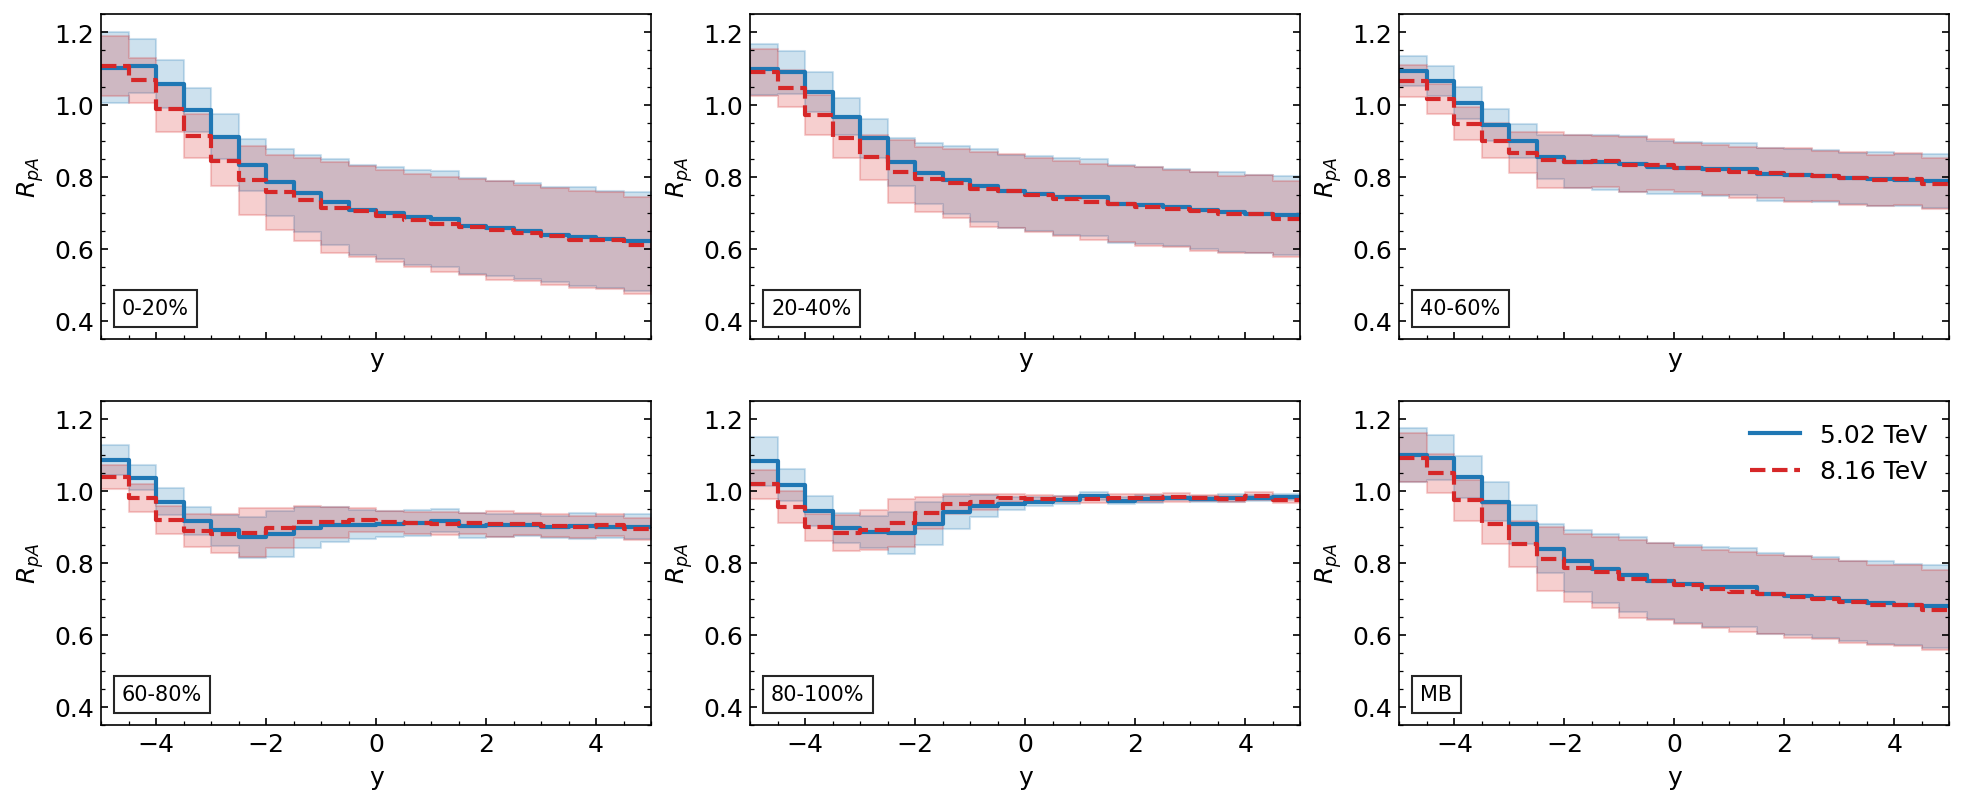

In [54]:
# panels: 5 centralities + MB
Y_NCOLS = 3  # change to 2/3/4 as you like
tags_y = [f"{a}-{b}%" for (a,b) in cent_bins] + ["MB"]
n_pan   = len(tags_y)
n_rows  = int(np.ceil(n_pan / Y_NCOLS))
n_cols  = Y_NCOLS

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.3*n_cols, 3.0*n_rows),
                         dpi=DPI, sharex=True, sharey=True)
axes = np.atleast_1d(axes).ravel()

handles_ = []
labels_  = []

for ip, tag in enumerate(tags_y):
    ax = axes[ip]

    for ETAG, dfmap, sysX in [("5.02", df49_by_cent_5, sys5), ("8.16", df49_by_cent_8, sys8)]:
        # source table (centrality or MB stack)
        if tag != "MB":
            df49 = dfmap[tag].copy()
            df49["wcent"] = 1.0
        else:
            rows = []
            for (a,b) in cent_bins:
                ctag = f"{a}-{b}%"
                tmp = dfmap[ctag].copy()
                tmp["wcent"] = WCENT[ctag] ## with centrality weights
                rows.append(tmp)
            df49 = pd.concat(rows, ignore_index=True)

        # bin along y
        y_left, r0_band, rlo_band, rhi_band = [], [], [], []
        for yl, yr in zip(Y_EDGES[:-1], Y_EDGES[1:]):
            sub = df49[(df49["y"]>=yl) & (df49["y"]<yr) &
                       (df49["pt"]>=PT_RANGE_AVG[0]) & (df49["pt"]<=PT_RANGE_AVG[1])].copy()
            if sub.empty:
                y_left.append(yl); r0_band.append(np.nan); rlo_band.append(np.nan); rhi_band.append(np.nan); continue

            # weights (your inline block, unchanged behavior)
            wn = _get_weights(sub, sysX, ETAG)

            r0  = np.sum(wn * sub["r_central"].to_numpy())
            # member means in this y-bin (same weights) → Hessian band
            mem = np.array(
                [np.sum(wn * sub[c].to_numpy()) 
                 for c in sub.columns if c.startswith("r_mem_")],
                float
            )
            D   = mem[0::2] - mem[1::2]
            h   = 0.5*np.sqrt(np.sum(D*D))

            y_left.append(yl)
            r0_band.append(r0)
            rlo_band.append(r0 - h)
            rhi_band.append(r0 + h)

        # step bands
        x  = np.array(y_left, float)
        xC = np.r_[x, x[-1]+(x[1]-x[0])]
        yC = np.r_[r0_band, r0_band[-1]]
        yL = np.r_[rlo_band, rlo_band[-1]]
        yH = np.r_[rhi_band, rhi_band[-1]]

        ln, = ax.step(xC, yC, where="post", color=COLORS[ETAG], ls=LSTYLE[ETAG], lw=2.0, label=f"{ETAG} TeV")
        ax.fill_between(xC, yL, yH, step="post", color=COLORS[ETAG], alpha=ALPHA_BAND)
        handles_.append(ln); labels_.append(f"{ETAG} TeV")

        # optional CSV dump per panel/energy
        if SAVE_CSV:
            out = pd.DataFrame(dict(y_left=x, y_right=xC[:-1]+(x[1]-x[0]), r_central=yC[:-1], r_lo=yL[:-1], r_hi=yH[:-1]))
            out.to_csv(OUTDIR/f"data_rpa_vs_y_{tag.replace('%','pct')}_{ETAG.replace('.','p')}TeV.csv", index=False)

    # axis cosmetics + in-axis note (centrality tag or MB)
    beautify_axis(ax, xlabel="y", ylabel=r"$R_{pA}$",
                  xlim=(Y_EDGES[0], Y_EDGES[-1]), ylim=(0.35, 1.25))

    # --- NEW: show y-axis ticks & labels on BOTH sides for every panel ---
    ax.yaxis.set_ticks_position("both")
    ax.tick_params(axis="y", which="both", right=True, labelleft=True, labelright=False)

    put_note(ax, tag, loc="lower left")

# remove any empty axes
for k in range(n_pan, len(axes)):
    fig.delaxes(axes[k])

# single common legend → move into ONE subfigure (here: MB panel)
uniq = {}
for h,l in zip(handles_, labels_):
    uniq[l] = h

# choose which axis should host the legend; using MB panel here
try:
    mb_idx = tags_y.index("MB")
    legend_ax = axes[mb_idx]
except ValueError:
    legend_ax = axes[0]

legend_ax.legend(list(uniq.values()), list(uniq.keys()),
                 loc="upper right", frameon=False)

plt.subplots_adjust(top=0.90, hspace=0.19, wspace=0.18)
if SAVE_PDF:
    fig.savefig(OUTDIR/f"rpa_vs_y_panels_{WEIGHT_MODE}.pdf", bbox_inches="tight")
plt.show()

In [24]:
# # panels: 5 centralities + MB
# Y_NCOLS = 3  # change to 2/3/4 as you like
# tags_y = [f"{a}-{b}%" for (a,b) in cent_bins] + ["MB"]
# n_pan   = len(tags_y)
# n_rows  = int(np.ceil(n_pan / Y_NCOLS))
# n_cols  = Y_NCOLS

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.3*n_cols, 3.0*n_rows),
#                          dpi=DPI, sharex=True, sharey=True)
# axes = np.atleast_1d(axes).ravel()

# handles_ = []
# labels_  = []

# for ip, tag in enumerate(tags_y):
#     ax = axes[ip]

#     for ETAG, dfmap, sysX in [("5.02", df49_by_cent_5, sys5), ("8.16", df49_by_cent_8, sys8)]:
#         # source table (centrality or MB stack)
#         if tag != "MB":
#             df49 = dfmap[tag].copy()
#             df49["wcent"] = 1.0
#         else:
#             rows = []
#             for (a,b) in cent_bins:
#                 ctag = f"{a}-{b}%"
#                 tmp = dfmap[ctag].copy()
#                 tmp["wcent"] = WCENT[ctag]
#                 rows.append(tmp)
#             df49 = pd.concat(rows, ignore_index=True)

#         # bin along y
#         y_left, r0_band, rlo_band, rhi_band = [], [], [], []
#         for yl, yr in zip(Y_EDGES[:-1], Y_EDGES[1:]):
#             sub = df49[(df49["y"]>=yl) & (df49["y"]<yr) &
#                        (df49["pt"]>=PT_RANGE_AVG[0]) & (df49["pt"]<=PT_RANGE_AVG[1])].copy()
#             if sub.empty:
#                 y_left.append(yl); r0_band.append(np.nan); rlo_band.append(np.nan); rhi_band.append(np.nan); continue

#             # weights (your inline block, unchanged behavior)
#             mode = WEIGHT_MODE
#             if mode == "flat":
#                 w = np.ones(len(sub), float)
#             elif mode == "pa@y0":
#                 lut = {}
#                 for ptv, grp in sysX.df_pa.groupby("pt"):
#                     ys=grp["y"].to_numpy(); vals=grp["val"].to_numpy()
#                     j = int(np.argmin(np.abs(ys - Y_REF)))
#                     lut[float(ptv)] = float(vals[j])
#                 w = sub["pt"].map(lambda v: lut.get(float(v), 0.0)).to_numpy()
#             elif mode == "pa@local":
#                 lut = {(float(r.y),float(r.pt)):float(r.val) for r in sysX.df_pa.itertuples()}
#                 w = np.array([lut.get((float(r.y),float(r.pt)),0.0) for r in sub.itertuples()], float)
#             elif mode == "pp@local":
#                 lut = {(float(r.y),float(r.pt)):float(r.val) for r in sysX.df_pp.itertuples()}
#                 w = np.array([lut.get((float(r.y),float(r.pt)),0.0) for r in sub.itertuples()], float)
#             elif mode == "SA@y0":
#                 puniq = np.sort(sub["pt"].unique())
#                 gprov = epps5 if ETAG=="5.02" else epps8
#                 SAref = gprov.SA_ypt_set(np.full_like(puniq, Y_REF), puniq, set_id=1)
#                 lut   = {float(p):float(v) for p,v in zip(puniq, SAref)}
#                 w     = sub["pt"].map(lambda v: lut.get(float(v), 0.0)).to_numpy()
#             else:
#                 raise ValueError

#             # include centrality fraction for MB panels
#             w *= sub["wcent"].to_numpy()

#             # low-pT σ-weight hygiene (keeps peripheral y-dip from spiky weights)
#             if PT_FLOOR_W is not None and mode not in ("flat","SA@y0"):
#                 mask_bad = (sub["pt"].to_numpy() < float(PT_FLOOR_W))
#                 if Y_GUARD_MAX is not None:
#                     mask_bad &= (sub["y"].to_numpy() <= float(Y_GUARD_MAX))
#                 if np.any(mask_bad):
#                     src = sysX.df_pa if mode.startswith("pa@") else sysX.df_pp
#                     for yy in np.unique(sub.loc[mask_bad,"y"].to_numpy()):
#                         cand = src[(src["y"]==float(yy)) & (src["pt"]>=float(PT_FLOOR_W))].sort_values("pt")
#                         if len(cand): w[(sub["y"].to_numpy()==yy)&mask_bad] = float(cand["val"].iloc[0])

#             if (WINSOR is not None) and np.any(w>0):
#                 cap = float(WINSOR[1]) * np.nanquantile(w[w>0], float(WINSOR[0]))
#                 w   = np.clip(w, 0.0, cap)

#             wn = (w/np.sum(w)) if np.sum(w)>0 else np.ones_like(w)/len(w)

#             r0  = np.sum(wn * sub["r_central"].to_numpy())
#             mem = [np.sum(wn * sub[c].to_numpy()) for c in sub.columns if c.startswith("r_mem_")]
#             mem = np.asarray(mem, float)
#             D   = mem[0::2] - mem[1::2]
#             h   = 0.5*np.sqrt(np.sum(D*D))

#             y_left.append(yl); r0_band.append(r0); rlo_band.append(r0-h); rhi_band.append(r0+h)

#         # step bands
#         x  = np.array(y_left, float)
#         xC = np.r_[x, x[-1]+(x[1]-x[0])]
#         yC = np.r_[r0_band, r0_band[-1]]
#         yL = np.r_[rlo_band, rlo_band[-1]]
#         yH = np.r_[rhi_band, rhi_band[-1]]

#         ln, = ax.step(xC, yC, where="post", color=COLORS[ETAG], ls=LSTYLE[ETAG], lw=2.0, label=f"{ETAG} TeV")
#         ax.fill_between(xC, yL, yH, step="post", color=COLORS[ETAG], alpha=ALPHA_BAND)
#         handles_.append(ln); labels_.append(f"{ETAG} TeV")

#         # optional CSV dump per panel/energy
#         if SAVE_CSV:
#             out = pd.DataFrame(dict(y_left=x, y_right=xC[:-1]+(x[1]-x[0]), r_central=yC[:-1], r_lo=yL[:-1], r_hi=yH[:-1]))
#             out.to_csv(OUTDIR/f"data_rpa_vs_y_{tag.replace('%','pct')}_{ETAG.replace('.','p')}TeV.csv", index=False)

#     # axis cosmetics + in-axis note (centrality tag or MB)
#     beautify_axis(ax, xlabel="y", ylabel=r"$R_{pA}$",
#                   xlim=(Y_EDGES[0], Y_EDGES[-1]), ylim=(0.35, 1.25))

#     # --- NEW: show y-axis ticks & labels on BOTH sides for every panel ---
#     ax.yaxis.set_ticks_position("both")
#     ax.tick_params(axis="y", which="both", right=True, labelleft=True, labelright=False)

#     put_note(ax, tag, loc="lower left")

# # remove any empty axes
# for k in range(n_pan, len(axes)):
#     fig.delaxes(axes[k])

# # single common legend → move into ONE subfigure (here: MB panel)
# uniq = {}
# for h,l in zip(handles_, labels_):
#     uniq[l] = h

# # choose which axis should host the legend; using MB panel here
# try:
#     mb_idx = tags_y.index("MB")
#     legend_ax = axes[mb_idx]
# except ValueError:
#     legend_ax = axes[0]

# legend_ax.legend(list(uniq.values()), list(uniq.keys()),
#                  loc="upper right", frameon=False)

# plt.subplots_adjust(top=0.90, hspace=0.19, wspace=0.18)
# if SAVE_PDF:
#     fig.savefig(OUTDIR/f"rpa_vs_y_panels_{WEIGHT_MODE}.pdf", bbox_inches="tight")
# plt.show()

### Improvement

In [25]:
# ---------- tiny helpers (local, minimal-change) ---------------------------------

def _choose_weight_mode_for_ybin(tag, yl, yr, base_mode, periph_policy="auto"):
    """
    Return weight mode for this y-slab.
      periph_policy:
        - "auto" : for peripheral (60–80, 80–100, MB) AND yr<=0 → use "pp@y0";
                   otherwise keep base_mode
        - "none" : always keep base_mode
        - explicit : "pp@y0", "pp@local", "SA@y0", "pa@y0" to force in those periph/backward slabs
    """
    if periph_policy == "none":
        return base_mode
    is_periph = tag.startswith("60-") or tag.startswith("80-") or (tag == "MB")
    is_backward_bin = (yr <= 0.0)
    if is_periph and is_backward_bin:
        if periph_policy in ("auto", "pp@y0"):
            return "pp@y0"
        elif periph_policy in ("SA@y0", "pa@y0", "pp@local"):
            return periph_policy
    return base_mode


def _get_weights_ybin(sub, sysX, ETAG, *,
                      mode, Y_REF=0.0, PT_FLOOR_W=None, Y_GUARD_MAX=None, WINSOR=None):
    """
    Exact weight logic you already use, wrapped so `sysX` is always in scope.
    """
    # ---- base weights (unchanged logic)
    if mode == "flat":
        w = np.ones(len(sub), float)
    
    elif mode == "pp@y0":  # NEW: use σ_pp shape at reference rapidity for ALL bins
        lut = {}
        for ptv, grp in sysX.df_pp.groupby("pt"):
            ys = grp["y"].to_numpy(); vals = grp["val"].to_numpy()
            j  = int(np.argmin(np.abs(ys - Y_REF)))  # or Y_REF passed in kwargs
            lut[float(ptv)] = float(vals[j])
        w = sub["pt"].map(lambda v: lut.get(float(v), 0.0)).to_numpy()

    elif mode == "pa@y0":
        lut = {}
        for ptv, grp in sysX.df_pa.groupby("pt"):
            ys = grp["y"].to_numpy(); vals = grp["val"].to_numpy()
            j  = int(np.argmin(np.abs(ys - Y_REF)))
            lut[float(ptv)] = float(vals[j])
        w = sub["pt"].map(lambda v: lut.get(float(v), 0.0)).to_numpy()

    elif mode == "pa@local":
        lut = {(float(r.y), float(r.pt)): float(r.val) for r in sysX.df_pa.itertuples()}
        w = np.array([lut.get((float(r.y), float(r.pt)), 0.0) for r in sub.itertuples()], float)

    elif mode == "pp@local":
        lut = {(float(r.y), float(r.pt)): float(r.val) for r in sysX.df_pp.itertuples()}
        w = np.array([lut.get((float(r.y), float(r.pt)), 0.0) for r in sub.itertuples()], float)

    elif mode == "SA@y0":
        puniq = np.sort(sub["pt"].unique())
        gprov = epps5 if ETAG == "5.02" else epps8
        SAref = gprov.SA_ypt_set(np.full_like(puniq, Y_REF), puniq, set_id=1)
        lut   = {float(p): float(v) for p, v in zip(puniq, SAref)}
        w     = sub["pt"].map(lambda v: lut.get(float(v), 0.0)).to_numpy()

    else:
        raise ValueError(f"Unknown WEIGHT_MODE={mode}")

    # ---- σ-weight truncation at very low pT (only for σ-based modes, optional)
    if (PT_FLOOR_W is not None) and (mode not in ("flat", "SA@y0")):
        mask_bad = (sub["pt"].to_numpy() < float(PT_FLOOR_W))
        if Y_GUARD_MAX is not None:
            mask_bad &= (sub["y"].to_numpy() <= float(Y_GUARD_MAX))
        if np.any(mask_bad):
            src = sysX.df_pa if mode.startswith("pa@") else sysX.df_pp
            for yy in np.unique(sub.loc[mask_bad, "y"].to_numpy()):
                cand = src[(src["y"] == float(yy)) & (src["pt"] >= float(PT_FLOOR_W))].sort_values("pt")
                if len(cand):
                    w[(sub["y"].to_numpy() == yy) & mask_bad] = float(cand["val"].iloc[0])

    # ---- winsorize long tails in σ-weights (unchanged)
    if (WINSOR is not None) and np.any(w > 0):
        cap = float(WINSOR[1]) * np.nanquantile(w[w > 0], float(WINSOR[0]))
        w   = np.clip(w, 0.0, cap)

    s = np.sum(w)
    return (w / s) if (s > 0) else (np.ones_like(w, float) / len(w))


# ---------- final plotting function --------------------------------------------

def plot_rpa_vs_y_panels(*,
                         y_edges=None,               # default: global Y_EDGES
                         pt_range=(1.5, 20.0),       # flexible pT window for averaging
                         cols=3,                     # # of columns in the panel grid
                         periph_weight="auto",       # "auto"|"none"|explicit ("pp@local"/"SA@y0")
                         weight_override=None,     # NEW: None, or "pp@y0", "pp@local", ...
                         save_pdf=True, save_csv=False,
                         filename_tag=None,
                         colors=None, lstyle=None,
                         alpha_band=0.22, dpi=None):
    """
    Publication-ready R_pA vs y panels (5 centralities + MB), with peripheral-backward
    weighting softened in a physics-consistent way. Minimal-change everywhere else.

    periph_weight="auto": in (60–80, 80–100, MB) AND y-bin with yr<=0, use "pp@local";
                          elsewhere use global WEIGHT_MODE unchanged.
    """
    # --- globals fallback (keeps your notebook knobs intact)
    if y_edges is None:    y_edges = Y_EDGES
    if dpi is None:        dpi = DPI
    if colors is None:     colors = COLORS
    if lstyle is None:     lstyle = LSTYLE
    if filename_tag is None: filename_tag = WEIGHT_MODE

    tags = [f"{a}-{b}%" for (a,b) in cent_bins] + ["MB"]
    n_pan = len(tags)
    n_cols = cols
    n_rows = int(np.ceil(n_pan / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(5.2*n_cols, 2.9*n_rows),
                             dpi=dpi, sharex=True, sharey=True)
    axes = np.atleast_1d(axes).ravel()

    handles_, labels_ = [], []

    for ip, tag in enumerate(tags):
        ax = axes[ip]

        for ETAG, dfmap, sysX in [("5.02", df49_by_cent_5, sys5),
                                  ("8.16", df49_by_cent_8, sys8)]:

            # select centrality or MB stack (unchanged)
            if tag != "MB":
                df49 = dfmap[tag].copy()
                df49["wcent"] = 1.0
            else:
                rows = []
                for (a,b) in cent_bins:
                    tmp = dfmap[f"{a}-{b}%"].copy()
                    tmp["wcent"] = (b - a)/100.0
                    rows.append(tmp)
                df49 = pd.concat(rows, ignore_index=True)

            y_left, y_right, r0_band, rlo_band, rhi_band = [], [], [], [], []
            for yl, yr in zip(y_edges[:-1], y_edges[1:]):
                sub = df49[(df49["y"] >= yl) & (df49["y"] < yr) &
                           (df49["pt"] >= float(pt_range[0])) &
                           (df49["pt"] <= float(pt_range[1]))].copy()
                if sub.empty:
                    y_left.append(yl); y_right.append(yr)
                    r0_band.append(np.nan); rlo_band.append(np.nan); rhi_band.append(np.nan)
                    continue

                # peripheral/backward-aware weight choice (ONLY change we make)
                # mode_eff = _choose_weight_mode_for_ybin(tag, yl, yr, WEIGHT_MODE, periph_policy=periph_weight)
                # choose weight mode
                if weight_override is not None:
                    mode_eff = weight_override          # force everywhere
                    
                else:
                    mode_eff = _choose_weight_mode_for_ybin(tag, yl, yr, WEIGHT_MODE,
                                                            periph_policy=periph_weight)
                

                wn = _get_weights_ybin(sub, sysX, ETAG,
                                       mode=mode_eff,
                                       Y_REF=Y_REF,
                                       PT_FLOOR_W=PT_FLOOR_W,
                                       Y_GUARD_MAX=Y_GUARD_MAX,
                                       WINSOR=WINSOR)

                # include centrality fraction for MB
                wn = wn * sub["wcent"].to_numpy()
                s  = np.sum(wn); wn = (wn/s) if s>0 else (np.ones_like(wn)/len(wn))

                r0  = float(np.sum(wn * sub["r_central"].to_numpy()))
                mem = np.array([np.sum(wn * sub[c].to_numpy()) for c in sub.columns if c.startswith("r_mem_")], float)
                D   = mem[0::2] - mem[1::2]
                h   = 0.5*np.sqrt(np.sum(D*D))

                y_left.append(yl); y_right.append(yr)
                r0_band.append(r0); rlo_band.append(r0 - h); rhi_band.append(r0 + h)

            # draw as step + band
            x  = np.array(y_left,  float)
            xr = np.array(y_right, float)
            xC = np.r_[x, xr[-1]]   # post-step endpoint
            yC = np.r_[r0_band, r0_band[-1]]
            yL = np.r_[rlo_band, rlo_band[-1]]
            yH = np.r_[rhi_band, rhi_band[-1]]

            ln, = ax.step(xC, yC, where="post", color=colors[ETAG], ls=lstyle[ETAG], lw=2.0, label=f"{ETAG} TeV")
            ax.fill_between(xC, yL, yH, step="post", color=colors[ETAG], alpha=alpha_band)
            handles_.append(ln); labels_.append(f"{ETAG} TeV")

            if save_csv:
                out = pd.DataFrame(dict(y_left=x, y_right=xr,
                                        r_central=yC[:-1], r_lo=yL[:-1], r_hi=yH[:-1]))
                out.to_csv((OUTDIR / f"data_rpa_vs_y_{tag.replace('%','pct')}_{ETAG.replace('.','p')}TeV.csv"),
                           index=False)

        # cosmetics (labels, range, note)
        beautify_axis(ax, xlabel="y", ylabel=r"$R_{pA}$",
                      xlim=(y_edges[0], y_edges[-1]), ylim=(0.35, 1.25))
        put_note(ax, tag, loc="lower left")

    # strip empty axes if any
    for k in range(n_pan, len(axes)):
        fig.delaxes(axes[k])

    # single common legend (unique labels)
    uniq = {}
    for h, l in zip(handles_, labels_):
        uniq[l] = h
    fig.legend(list(uniq.values()), list(uniq.keys()), loc="upper center", ncol=2, frameon=False)

    plt.subplots_adjust(top=0.90, hspace=0.25, wspace=0.15)
    if save_pdf:
        fig.savefig(OUTDIR / f"rpa_vs_y_panels_{filename_tag}.pdf", bbox_inches="tight")
    plt.show()
    return fig, axes

NameError: name 'Y_GUARD_MAX' is not defined

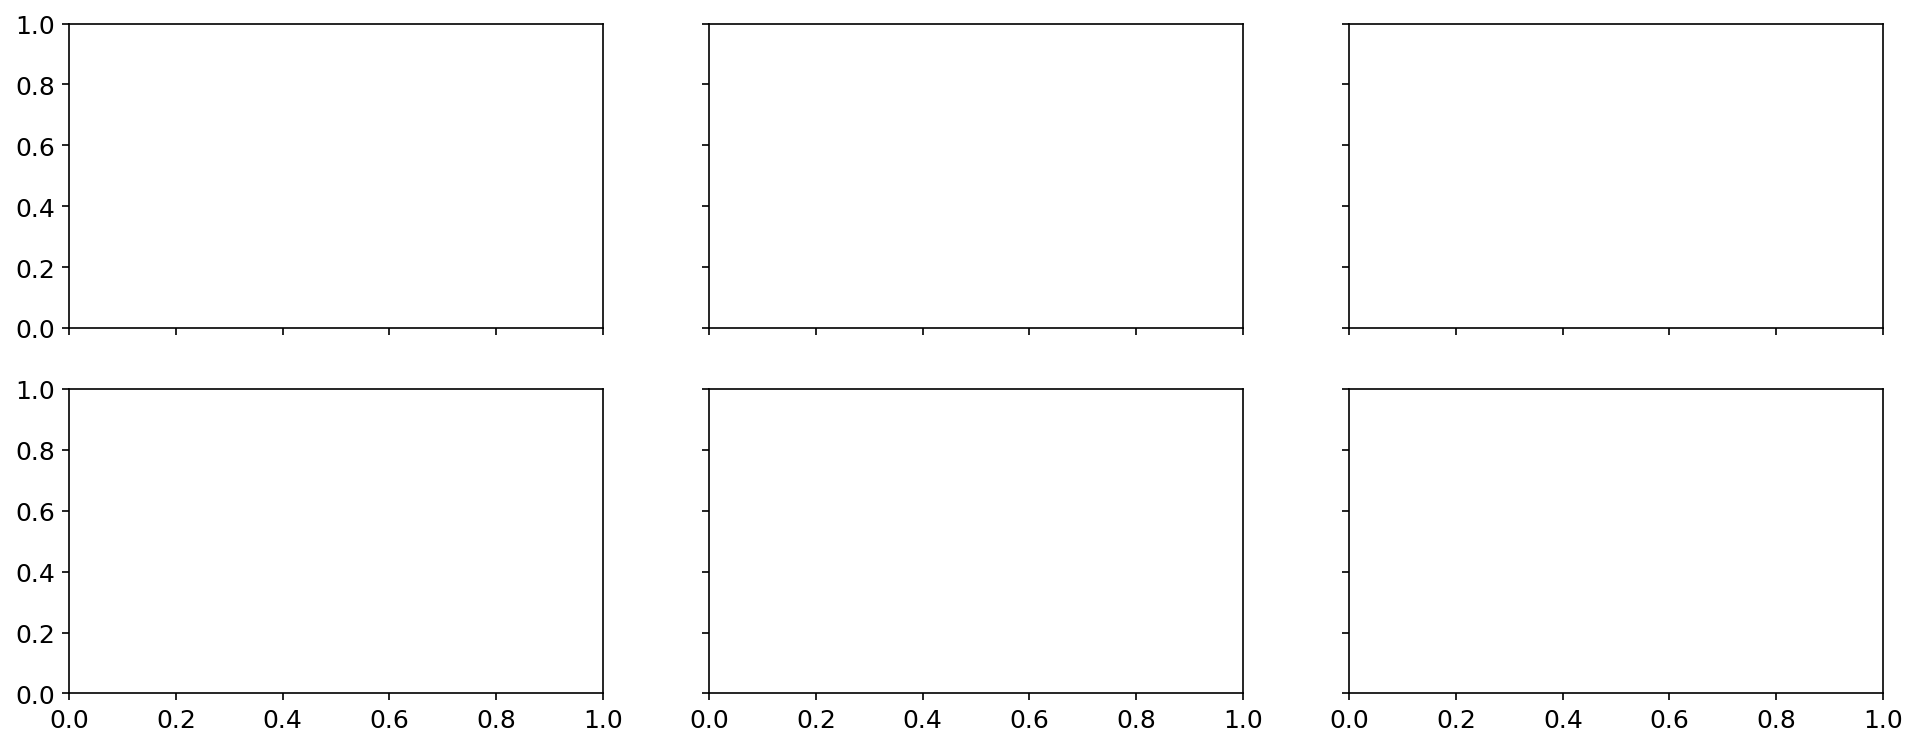

In [26]:
# default behavior (your current layout / weights)
plot_rpa_vs_y_panels(y_edges=Y_EDGES, pt_range=(3, 20.0), cols=Y_NCOLS,weight_override=None,
                     periph_weight="pp@y0", save_pdf=SAVE_PDF, save_csv=SAVE_CSV)

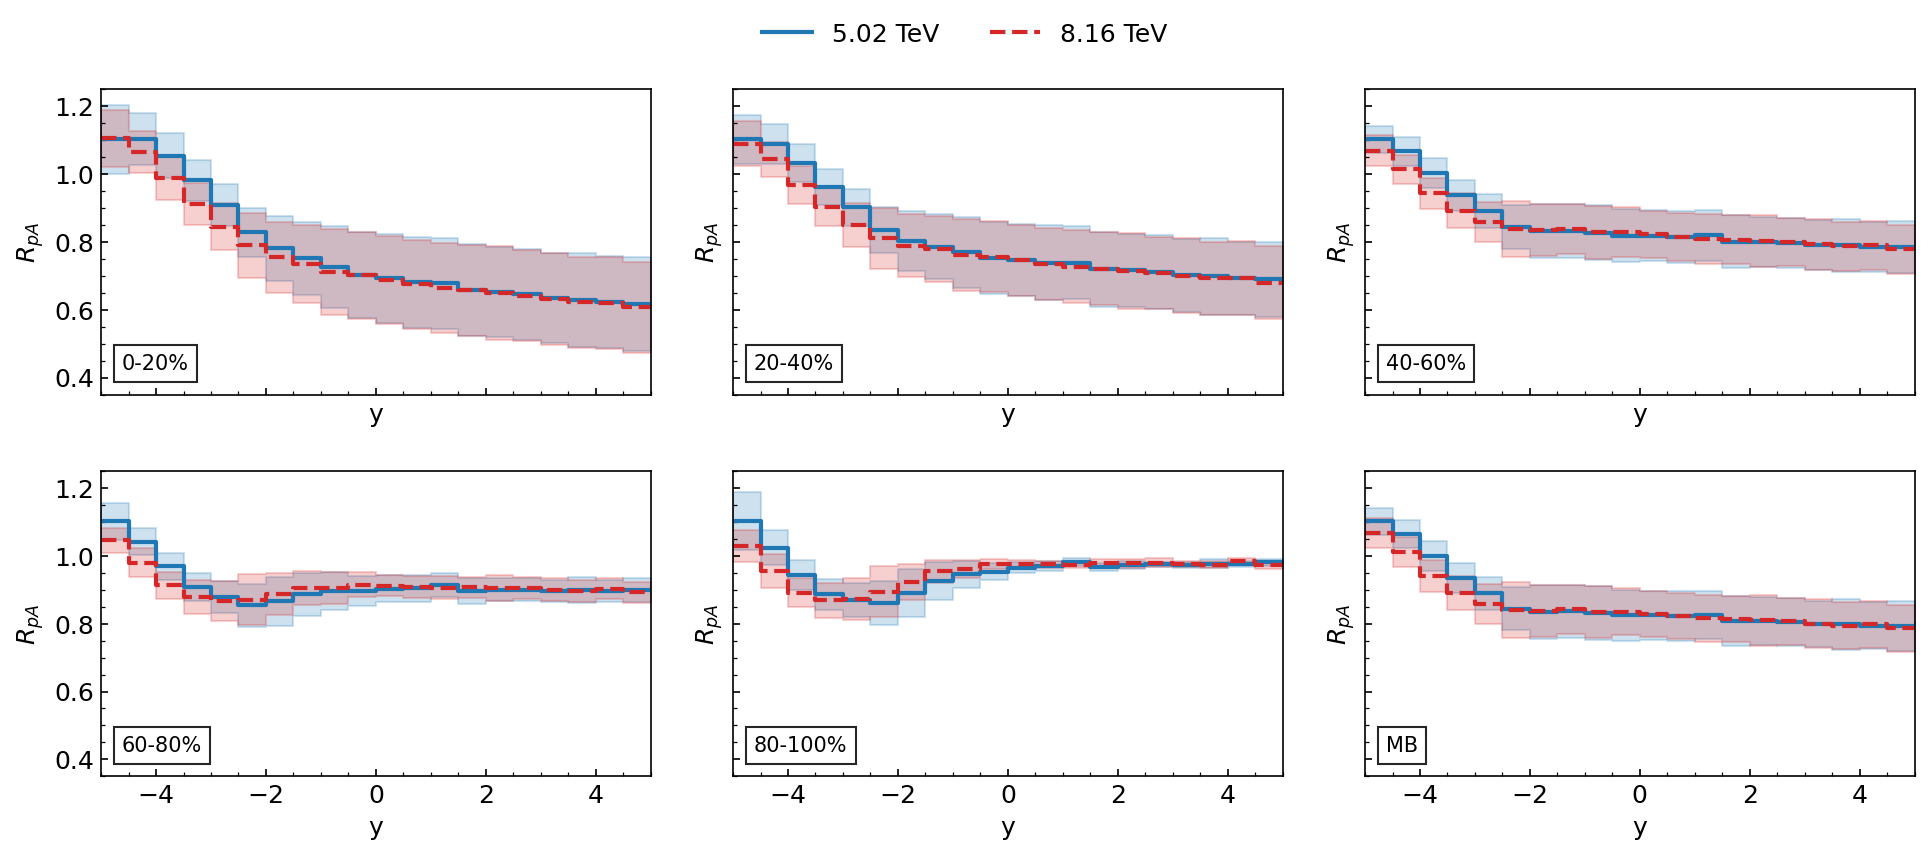

(<Figure size 2340x870 with 6 Axes>,
 array([<Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>], dtype=object))

In [ ]:
plot_rpa_vs_y_panels(y_edges=Y_EDGES, pt_range=(1.5, 20.0),
                     cols=Y_NCOLS,
                     weight_override="pp@y0",   # <- global switch
                     periph_weight="none",      # per-bin policy is bypassed anyway
                     save_pdf=SAVE_PDF, save_csv=SAVE_CSV)

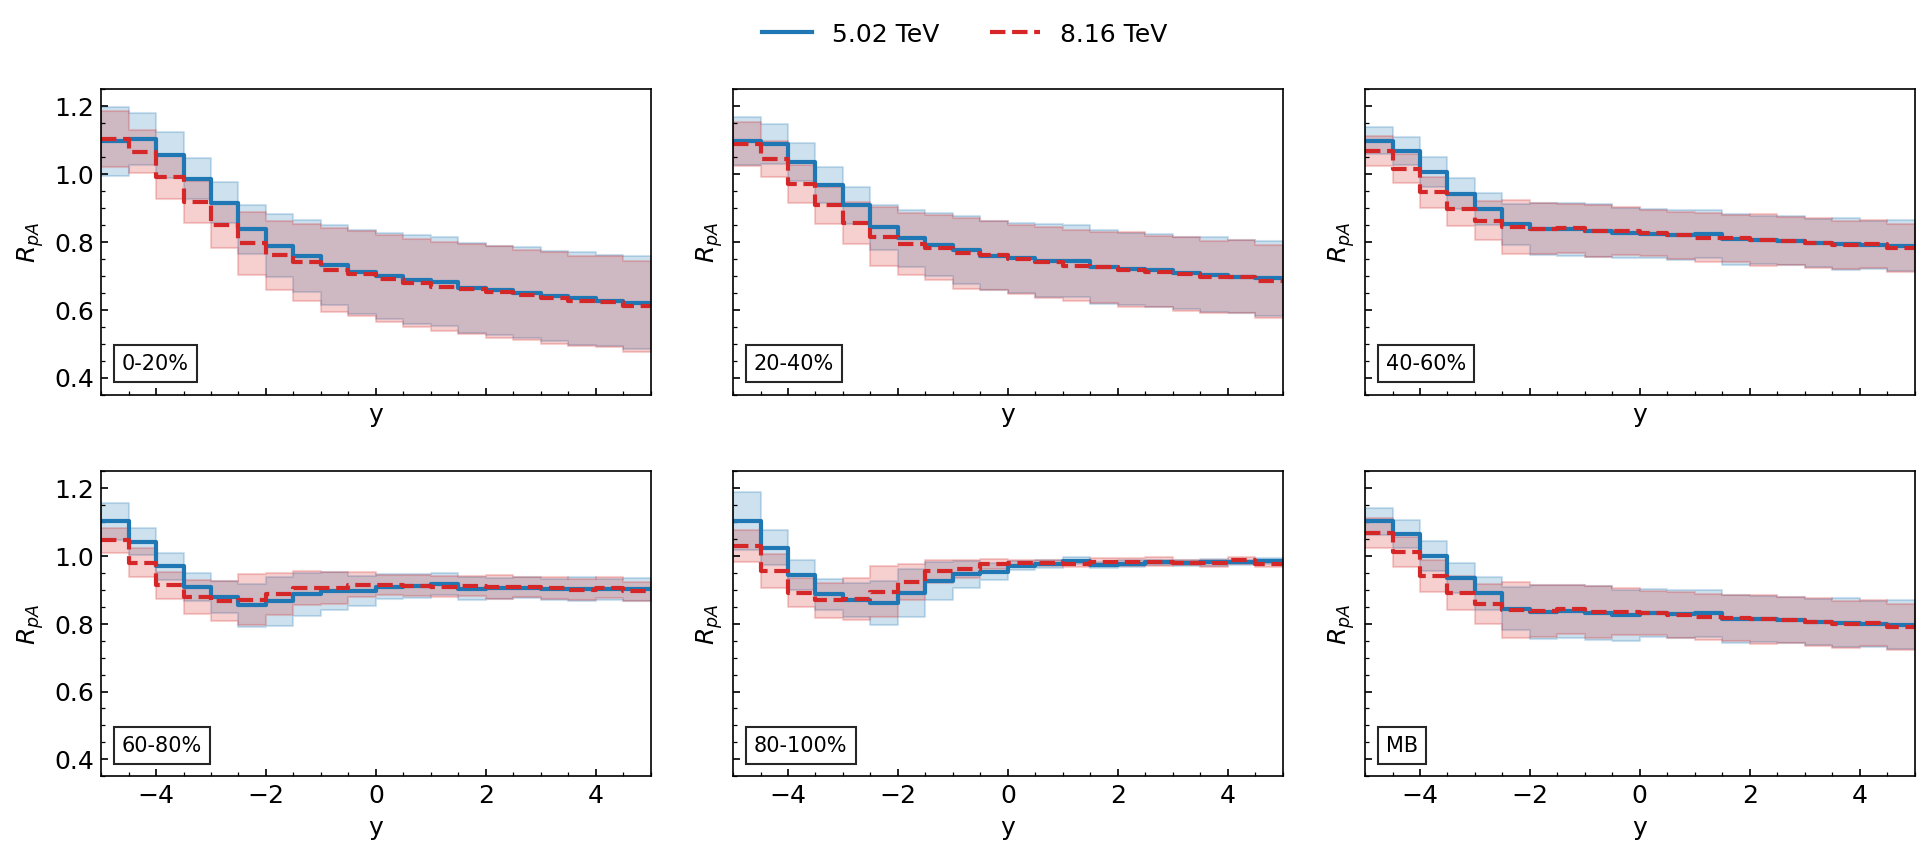

(<Figure size 2340x870 with 6 Axes>,
 array([<Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>], dtype=object))

In [ ]:
plot_rpa_vs_y_panels(y_edges=Y_EDGES, pt_range=(1.5, 20.0),
                     cols=Y_NCOLS,
                     periph_weight="auto",      # only periph & yr<=0 → "pp@y0"
                     weight_override=None,
                     save_pdf=SAVE_PDF, save_csv=SAVE_CSV)

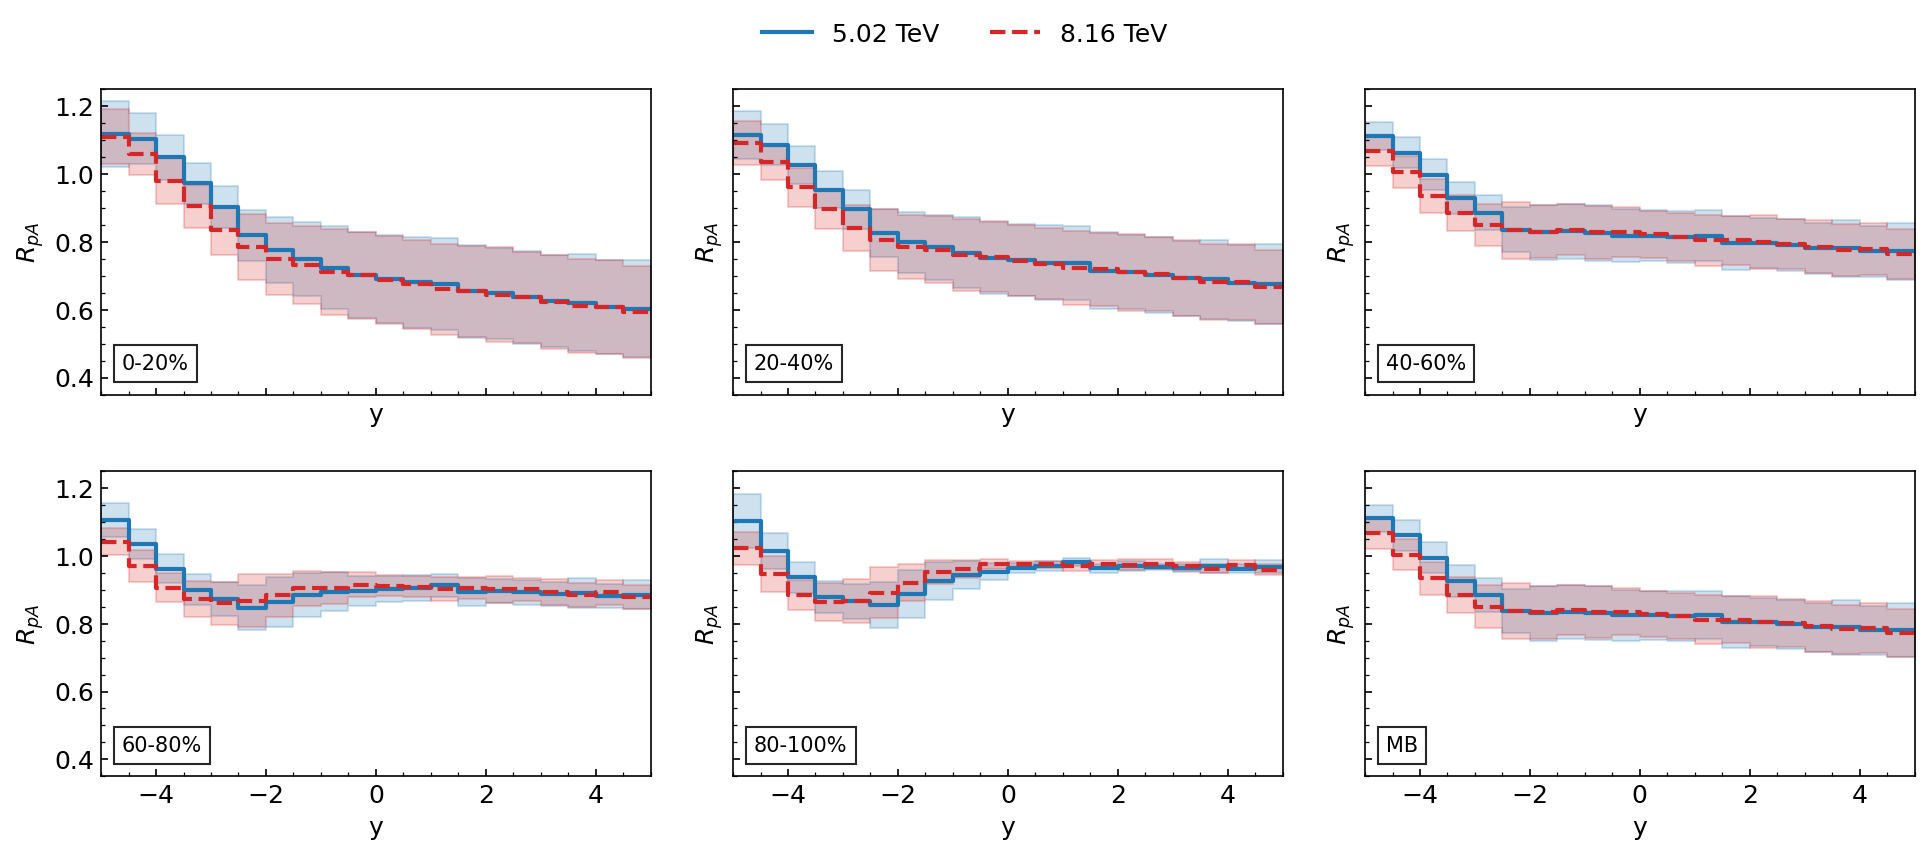

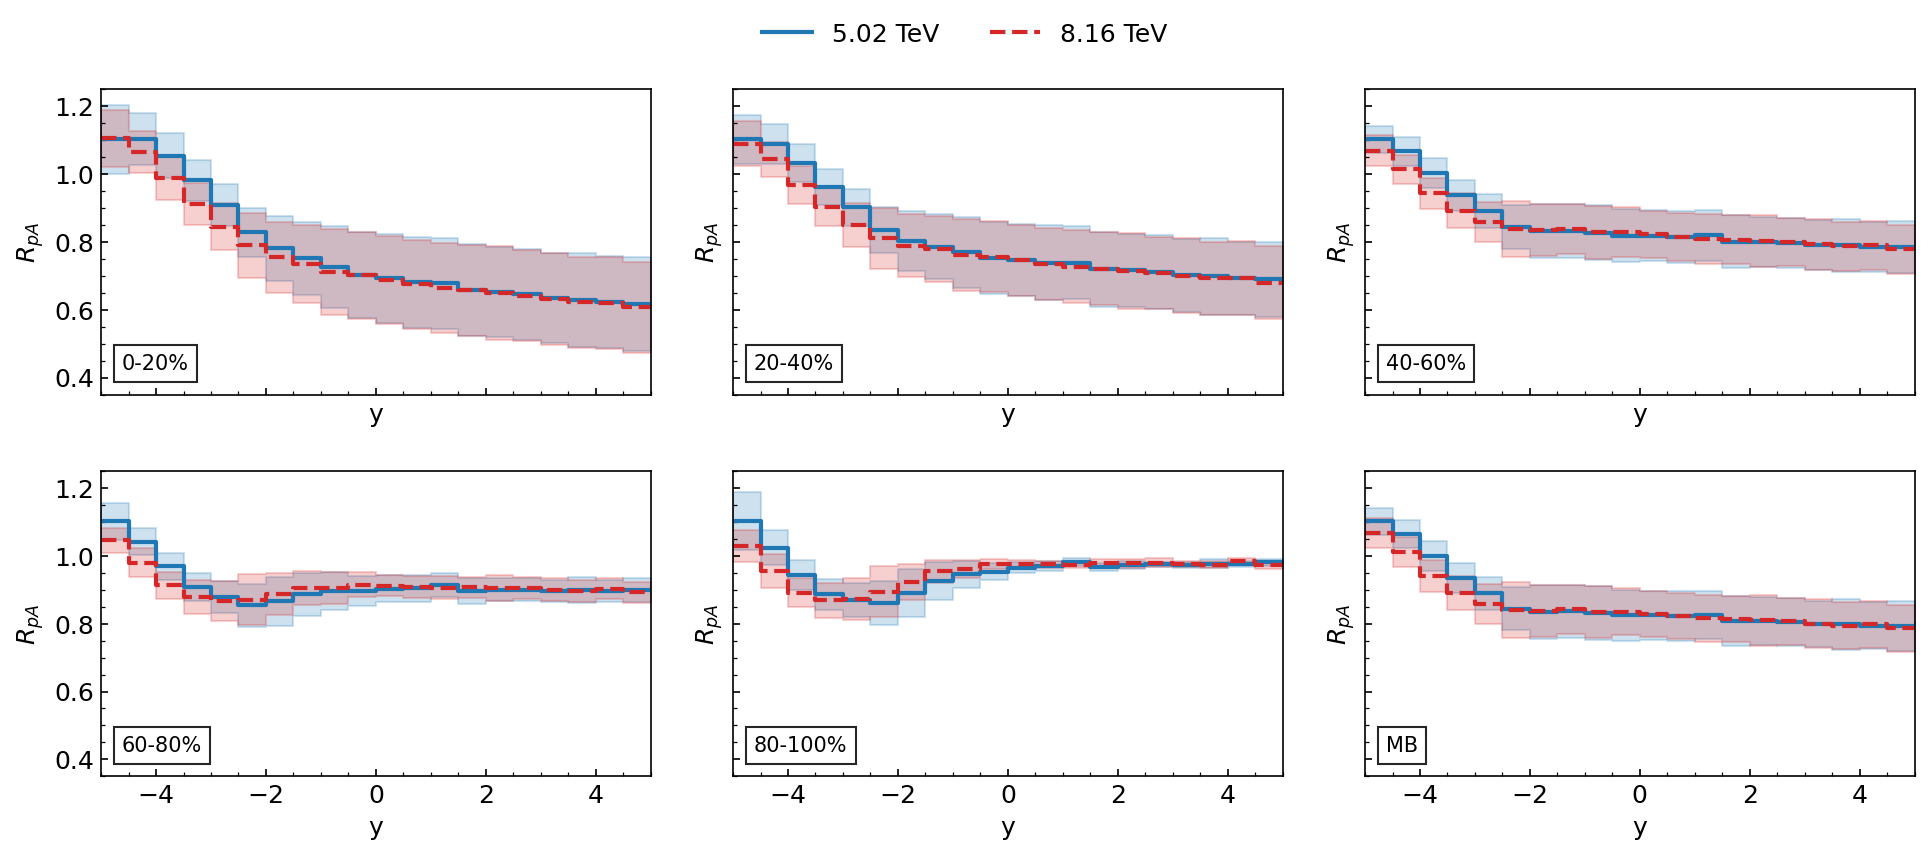

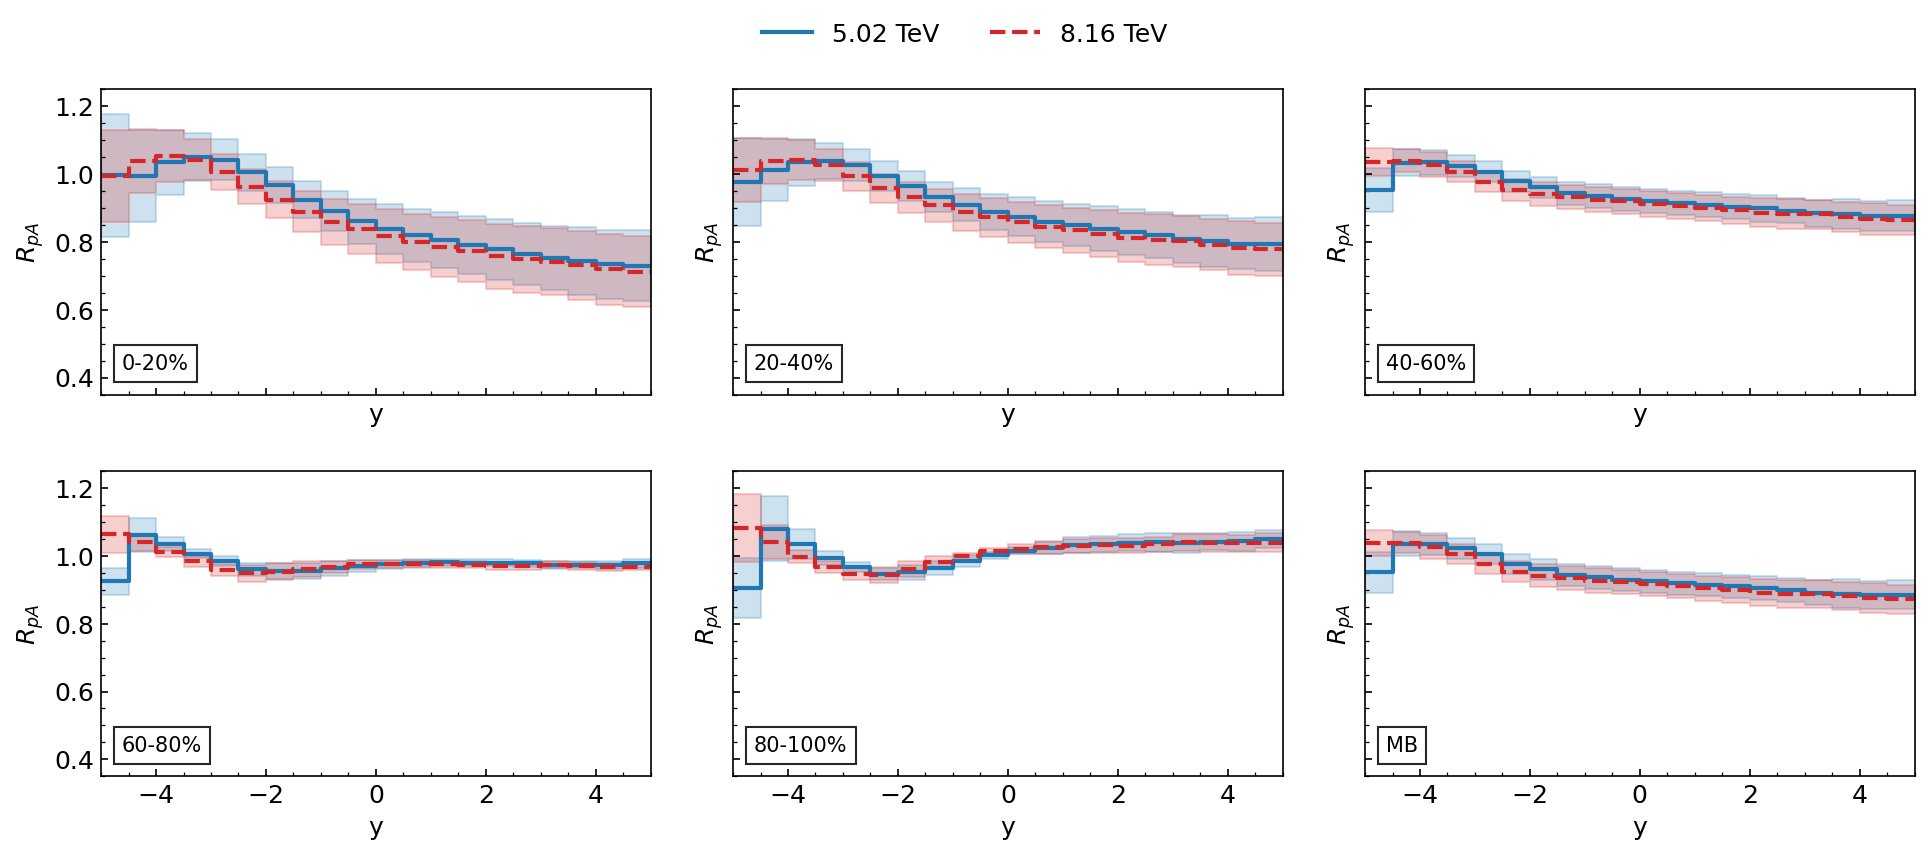

In [ ]:
for m in ["pp@local", "pp@y0", "flat"]:
    plot_rpa_vs_y_panels(pt_range=(1.5,20.0),
                         weight_override=m,
                         periph_weight="none",
                         save_pdf=False, save_csv=False,
                         filename_tag=f"compare_{m.replace('@','at')}")

In [ ]:
# # if you want to try SA@y0 in peripheral backward instead of pp@local:
# plot_rpa_vs_y_panels(periph_weight="SA@y0")

In [ ]:
# tighter pT window:
# plot_rpa_vs_y_panels(pt_range=(2.5, 20.0))

In [ ]:
# plot_rpa_vs_y_panels(periph_weight="auto",pt_range=(1.5, 20.0))

### Second fix try

In [ ]:
# ----------------------------- Hessian helpers ---------------------------------

def _hess_halfwidth_from_members(mem_vec_48: np.ndarray) -> float:
    # mem_vec_48 shape (48,); order guaranteed (+,-,+,-,...)
    D = mem_vec_48[0::2] - mem_vec_48[1::2]
    return 0.5 * float(np.sqrt(np.sum(D*D)))

def _bin_then_hessian(sub: pd.DataFrame, wn: np.ndarray) -> tuple[float,float,float]:
    """Bin each member with the same weights; then take Hessian."""
    rc = float(np.sum(wn * sub["r_central"].to_numpy()))
    mem = np.array([np.sum(wn * sub[c].to_numpy())
                    for c in sub.columns if c.startswith("r_mem_")], dtype=float)
    h = _hess_halfwidth_from_members(mem)
    return rc, rc - h, rc + h

def _hessian_then_bin(sub: pd.DataFrame, wn: np.ndarray) -> tuple[float,float,float]:
    """
    'Formal' Hessian-then-bin = bin each eigenvector set separately, then combine.
    (This is algebraically identical to bin_then_hessian as long as weights
     do not depend on the member; included for sanity/testing.)
    """
    rc = float(np.sum(wn * sub["r_central"].to_numpy()))
    # pairwise binned (+/-) values
    plus  = []; minus = []
    for k in range(1, 49, 2):
        r_plus  = float(np.sum(wn * sub[f"r_mem_{k:03d}"].to_numpy()))
        r_minus = float(np.sum(wn * sub[f"r_mem_{k+1:03d}"].to_numpy()))
        plus.append(r_plus); minus.append(r_minus)
    plus  = np.array(plus,  float)
    minus = np.array(minus, float)
    h = 0.5 * float(np.sqrt(np.sum((plus - minus)**2)))
    return rc, rc - h, rc + h

# ----------------------- peripheral/backward sanitizer -------------------------

PERIPH_BWD_FIX = dict(
    tags=("60-80%", "80-100%", "MB"),
    y_max=0.0,            # only y-bins entirely at y<=0
    lowpt_floor=2.5,      # soften <2.5 GeV in the WEIGHTS only
    share_trigger=0.25,   # activate if sub-2.5 GeV carries >25% of weight
    gamma=0.60,           # temper extremes: w -> w**gamma
    wcap=0.15,            # cap any single *normalized* weight at 15%
    taper_pow=2.0         # smooth taper for pT<floor: (pT/floor)^taper_pow
)
# --- tiny utility: identify peripheral-backward slabs ------------------------
def _is_periph(tag: str) -> bool:
    return tag.startswith("60-") or tag.startswith("80-") or (tag == "MB")

def _is_backward_bin(yl, yr) -> bool:
    return float(yr) <= 0.0  # whole slab at y ≤ 0

# --- controlled sanitizer on normalized weights (minimal & reversible) -------
def _sanitize_periph_backward_weights(wn, sub, *, lam=0.75, beta=0.6, pt0=2.5):
    """
    wn    : normalized weights from your chosen base mode
    sub   : the sub-DF (must have 'pt')
    lam   : 0<lam≤1 → lam<1 flattens spikes; lam=1 is no-op
    beta  : small ≥0 → nudges weight toward higher pT a bit (beta=0 no-op)
    pt0   : reference GeV for the mild pT tilt
    """
    if lam == 1.0 and (beta == 0.0 or beta is None):
        return wn  # no-op fast path
    pt = sub["pt"].to_numpy(float)
    w2 = (wn**lam) * ( (pt/float(pt0))**(beta if beta is not None else 0.0) )
    s  = np.sum(w2)
    return (w2/s) if s>0 else np.ones_like(w2)/len(w2)

# --- wrapper to compute normalized weights exactly like before ----------------
def _get_weights_ybin(sub, sysX, ETAG, *,
                      mode, Y_REF=0.0, PT_FLOOR_W=None, Y_GUARD_MAX=None, WINSOR=None):
    # (unchanged block; your exact logic)
    if mode == "flat":
        w = np.ones(len(sub), float)
    elif mode == "pa@y0":
        lut = {}
        for ptv, grp in sysX.df_pa.groupby("pt"):
            ys = grp["y"].to_numpy(); vals = grp["val"].to_numpy()
            j  = int(np.argmin(np.abs(ys - Y_REF))); lut[float(ptv)] = float(vals[j])
        w = sub["pt"].map(lambda v: lut.get(float(v), 0.0)).to_numpy()
    
    elif mode == "pp@y0":          # NEW
        lut = {}
        for ptv, grp in sysX.df_pp.groupby("pt"):
            ys = grp["y"].to_numpy(); vals = grp["val"].to_numpy()
            j  = int(np.argmin(np.abs(ys - Y_REF)))
            lut[float(ptv)] = float(vals[j])
        w = sub["pt"].map(lambda v: lut.get(float(v), 0.0)).to_numpy()
    
    elif mode == "pa@local":
        lut = {(float(r.y), float(r.pt)): float(r.val) for r in sysX.df_pa.itertuples()}
        w = np.array([lut.get((float(r.y), float(r.pt)), 0.0) for r in sub.itertuples()], float)
    elif mode == "pp@local":
        lut = {(float(r.y), float(r.pt)): float(r.val) for r in sysX.df_pp.itertuples()}
        w = np.array([lut.get((float(r.y), float(r.pt)), 0.0) for r in sub.itertuples()], float)
    elif mode == "SA@y0":
        puniq = np.sort(sub["pt"].unique()); gprov = epps5 if ETAG=="5.02" else epps8
        SAref = gprov.SA_ypt_set(np.full_like(puniq, Y_REF), puniq, set_id=1)
        lut   = {float(p): float(v) for p, v in zip(puniq, SAref)}
        w     = sub["pt"].map(lambda v: lut.get(float(v), 0.0)).to_numpy()
    else:
        raise ValueError(f"Unknown WEIGHT_MODE={mode}")

    # MB centrality fractions (unchanged)
    if "wcent" in sub.columns:
        w = w * sub["wcent"].to_numpy()

    # low-pT σ-weight hygiene (unchanged)
    if (PT_FLOOR_W is not None) and (mode not in ("flat","SA@y0")) and len(sub):
        mask_bad = (sub["pt"].to_numpy() < float(PT_FLOOR_W))
        if Y_GUARD_MAX is not None:
            mask_bad &= (sub["y"].to_numpy() <= float(Y_GUARD_MAX))
        if np.any(mask_bad):
            src = sysX.df_pa if mode.startswith("pa@") else sysX.df_pp
            for yy in np.unique(sub.loc[mask_bad, "y"].to_numpy()):
                cand = src[(src["y"]==float(yy))&(src["pt"]>=float(PT_FLOOR_W))].sort_values("pt")
                if len(cand):
                    w[(sub["y"].to_numpy()==yy)&mask_bad] = float(cand["val"].iloc[0])

    # winsorization (unchanged)
    if (WINSOR is not None) and np.any(w>0):
        cap = float(WINSOR[1]) * np.nanquantile(w[w>0], float(WINSOR[0]))
        w   = np.clip(w, 0.0, cap)

    s = np.sum(w)
    return (w/s) if s>0 else np.ones_like(w)/len(w)

# --- final panels with optional periph/backward sanitization -------------------
def plot_rpa_vs_y_panels_pub(*,
    y_edges=None, pt_range=(1.5,20.0), cols=3,
    periph_sanitize=True,  # <-- NEW: default on
    lam=0.75, beta=0.6, pt0=2.5,
    band_protocol="bin-then-hessian",  # or "hessian-then-bin"
    save_pdf=True, save_csv=False, filename_tag=None,
    colors=None, lstyle=None, alpha_band=0.22, dpi=None):

    if y_edges is None: y_edges = Y_EDGES
    if dpi is None: dpi = DPI
    if colors is None: colors = COLORS
    if lstyle is None: lstyle = LSTYLE
    if filename_tag is None: filename_tag = WEIGHT_MODE

    tags = [f"{a}-{b}%" for (a,b) in cent_bins] + ["MB"]
    n_cols, n_rows = cols, int(np.ceil(len(tags)/cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.2*n_cols, 2.9*n_rows),
                             dpi=dpi, sharex=True, sharey=True)
    axes = np.atleast_1d(axes).ravel()

    handles_, labels_ = [], []

    for ip, tag in enumerate(tags):
        ax = axes[ip]
        for ETAG, dfmap, sysX in [("5.02", df49_by_cent_5, sys5),
                                  ("8.16", df49_by_cent_8, sys8)]:

            # centrality slice (or MB stack)
            if tag != "MB":
                df49 = dfmap[tag].copy(); df49["wcent"] = 1.0
            else:
                rows=[]
                for (a,b) in cent_bins:
                    tmp = dfmap[f"{a}-{b}%"].copy()
                    tmp["wcent"] = (b-a)/100.0
                    rows.append(tmp)
                df49 = pd.concat(rows, ignore_index=True)

            yL_, yR_, rC_, rLo_, rHi_ = [], [], [], [], []
            for yl, yr in zip(y_edges[:-1], y_edges[1:]):
                sub = df49[(df49["y"]>=yl) & (df49["y"]<yr) &
                           (df49["pt"]>=float(pt_range[0])) &
                           (df49["pt"]<=float(pt_range[1]))].copy()
                yL_.append(yl); yR_.append(yr)
                if sub.empty:
                    rC_.append(np.nan); rLo_.append(np.nan); rHi_.append(np.nan); continue

                # base weights
                wn = _get_weights_ybin(sub, sysX, ETAG,
                                       mode=WEIGHT_MODE, Y_REF=Y_REF,
                                       PT_FLOOR_W=PT_FLOOR_W,
                                       Y_GUARD_MAX=Y_GUARD_MAX, WINSOR=WINSOR)

                # NEW: gentle, localized de-spiking in periph & backward bins
                if periph_sanitize and _is_periph(tag) and _is_backward_bin(yl, yr):
                    wn = _sanitize_periph_backward_weights(wn, sub, lam=lam, beta=beta, pt0=pt0)

                # normalize after MB factor
                if "wcent" in sub.columns:
                    wn = wn * sub["wcent"].to_numpy()
                    s  = np.sum(wn); wn = (wn/s) if s>0 else np.ones_like(wn)/len(wn)

                # band protocol: (i) bin then Hessian (recommended) or (ii) Hessian then bin
                if band_protocol == "bin-then-hessian":
                    r0  = float(np.sum(wn * sub["r_central"].to_numpy()))
                    mem = np.array([np.sum(wn * sub[c].to_numpy()) 
                                    for c in sub.columns if c.startswith("r_mem_")], float)
                    D   = mem[0::2] - mem[1::2]; h = 0.5*np.sqrt(np.sum(D*D))
                elif band_protocol == "hessian-then-bin":
                    # compute half-width at each point first, then weight both center & width
                    rc  = sub["r_central"].to_numpy()
                    hw  = []
                    for c in sub.columns:
                        pass
                    mem_cols = [c for c in sub.columns if c.startswith("r_mem_")]
                    mem_mat  = sub[mem_cols].to_numpy(float)     # (N,48)
                    # half-width per row:
                    D = mem_mat[:,0::2] - mem_mat[:,1::2]
                    hw = 0.5*np.sqrt(np.sum(D*D, axis=1))
                    r0 = float(np.sum(wn * rc))
                    h  = float(np.sum(wn * hw))
                else:
                    raise ValueError("band_protocol must be 'bin-then-hessian' or 'hessian-then-bin'")

                rC_.append(r0); rLo_.append(r0 - h); rHi_.append(r0 + h)

            # draw step + band
            x  = np.array(yL_, float); xr = np.array(yR_, float)
            xC = np.r_[x, xr[-1]]
            yC = np.r_[rC_, rC_[-1]]; yL = np.r_[rLo_, rLo_[-1]]; yH = np.r_[rHi_, rHi_[-1]]

            ln, = ax.step(xC, yC, where="post", color=colors[ETAG], ls=lstyle[ETAG], lw=2.0, label=f"{ETAG} TeV")
            ax.fill_between(xC, yL, yH, step="post", color=colors[ETAG], alpha=alpha_band)
            handles_.append(ln); labels_.append(f"{ETAG} TeV")

            if save_csv:
                out = pd.DataFrame(dict(y_left=x, y_right=xr, r_central=yC[:-1], r_lo=yL[:-1], r_hi=yH[:-1]))
                out.to_csv(OUTDIR / f"data_rpa_vs_y_{tag.replace('%','pct')}_{ETAG.replace('.','p')}TeV.csv", index=False)

        beautify_axis(ax, xlabel="y", ylabel=r"$R_{pA}$",
                      xlim=(y_edges[0], y_edges[-1]), ylim=(0.35, 1.25))
        put_note(ax, tag, loc="lower left")

    # cleanup & legend
    for k in range(len(tags), len(axes)): fig.delaxes(axes[k])
    uniq = {}; 
    for h,l in zip(handles_, labels_): uniq[l]=h
    fig.legend(list(uniq.values()), list(uniq.keys()), loc="upper center", ncol=2, frameon=False)

    plt.subplots_adjust(top=0.90, hspace=0.25, wspace=0.15)
    if save_pdf:
        fig.savefig(OUTDIR / f"rpa_vs_y_panels_{filename_tag}.pdf", bbox_inches="tight")
    plt.show()
    return fig, axes

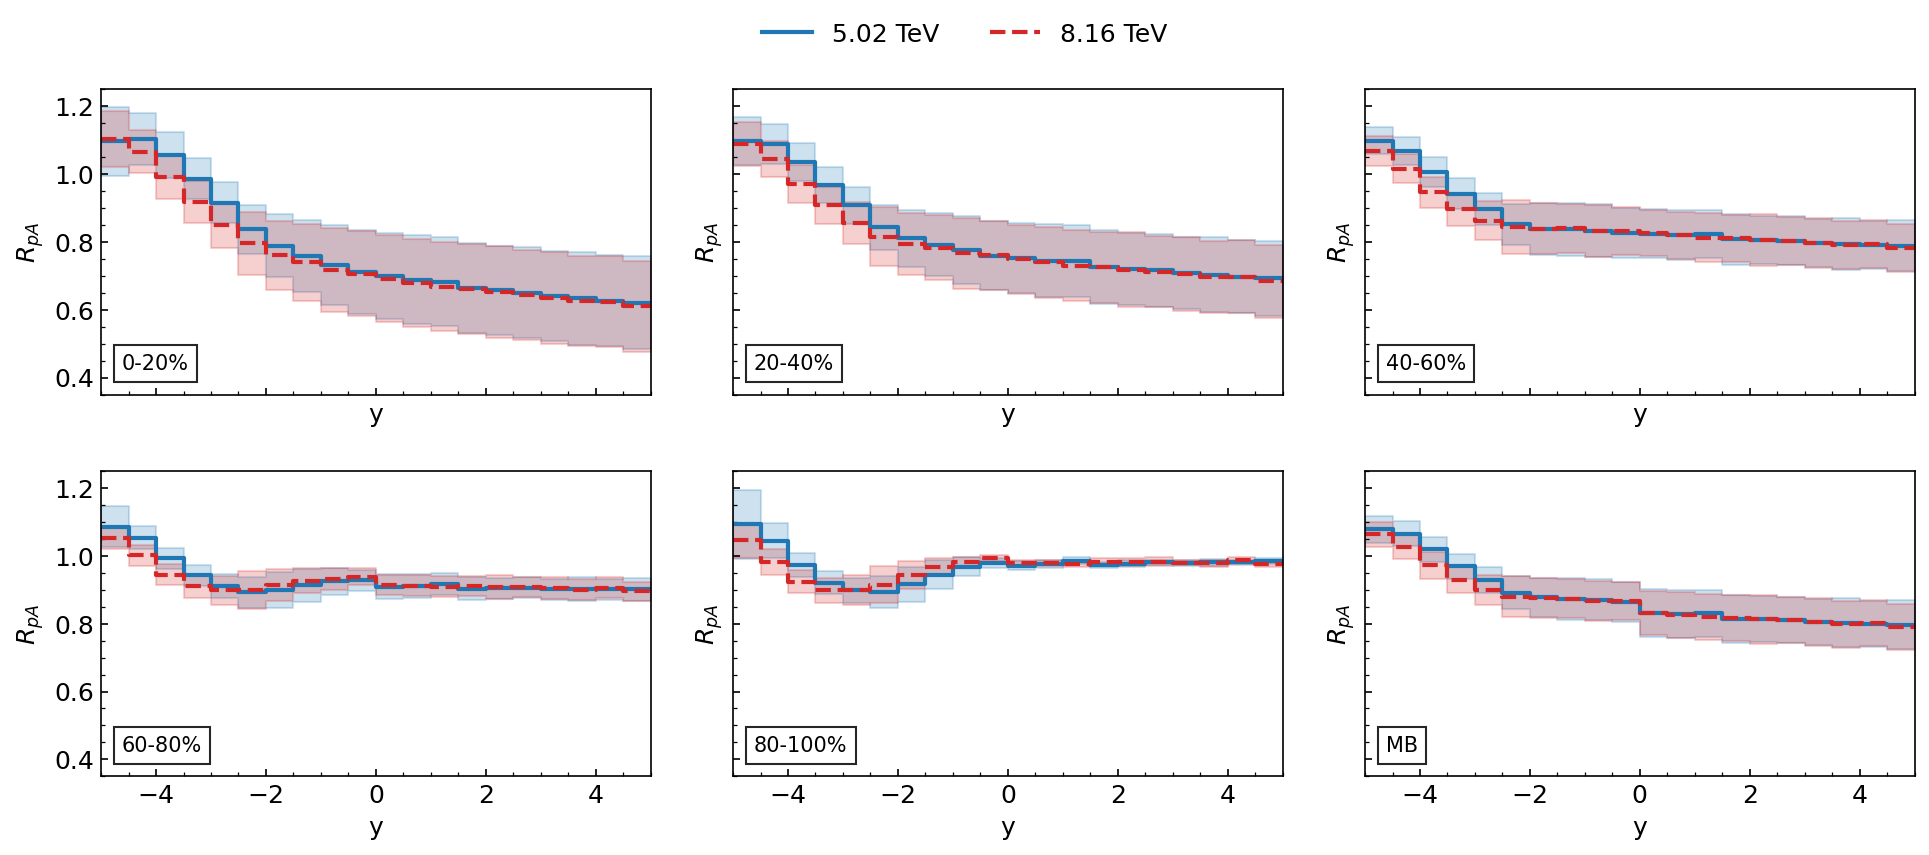

(<Figure size 2340x870 with 6 Axes>,
 array([<Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>], dtype=object))

In [ ]:
# (A) Publication default: physical weighting, gentle de-spike only where it hurts
plot_rpa_vs_y_panels_pub(
    y_edges=Y_EDGES, pt_range=(1.5, 20.0), cols=3,
    periph_sanitize=True, lam=0.75, beta=0.6, pt0=2.5,
    band_protocol="bin-then-hessian",  # your usual
    save_pdf=SAVE_PDF, save_csv=SAVE_CSV)

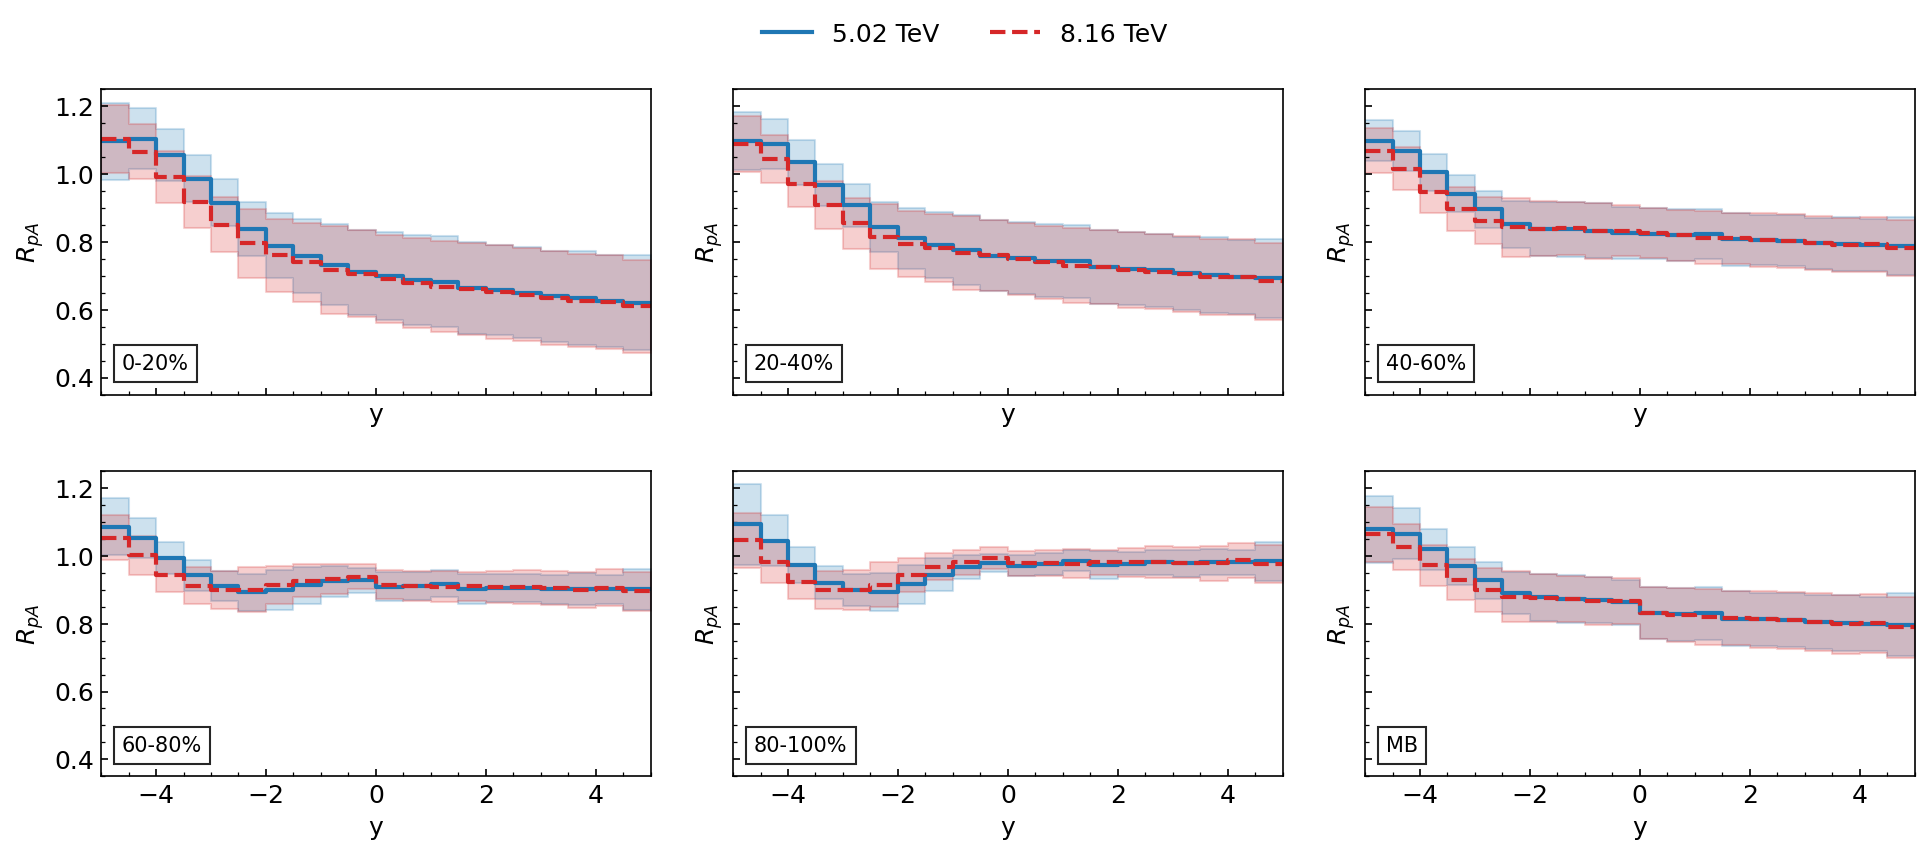

(<Figure size 2340x870 with 6 Axes>,
 array([<Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>], dtype=object))

In [ ]:
# (B) Cross-check that order barely matters with your weights:
plot_rpa_vs_y_panels_pub(band_protocol="hessian-then-bin", periph_sanitize=True)

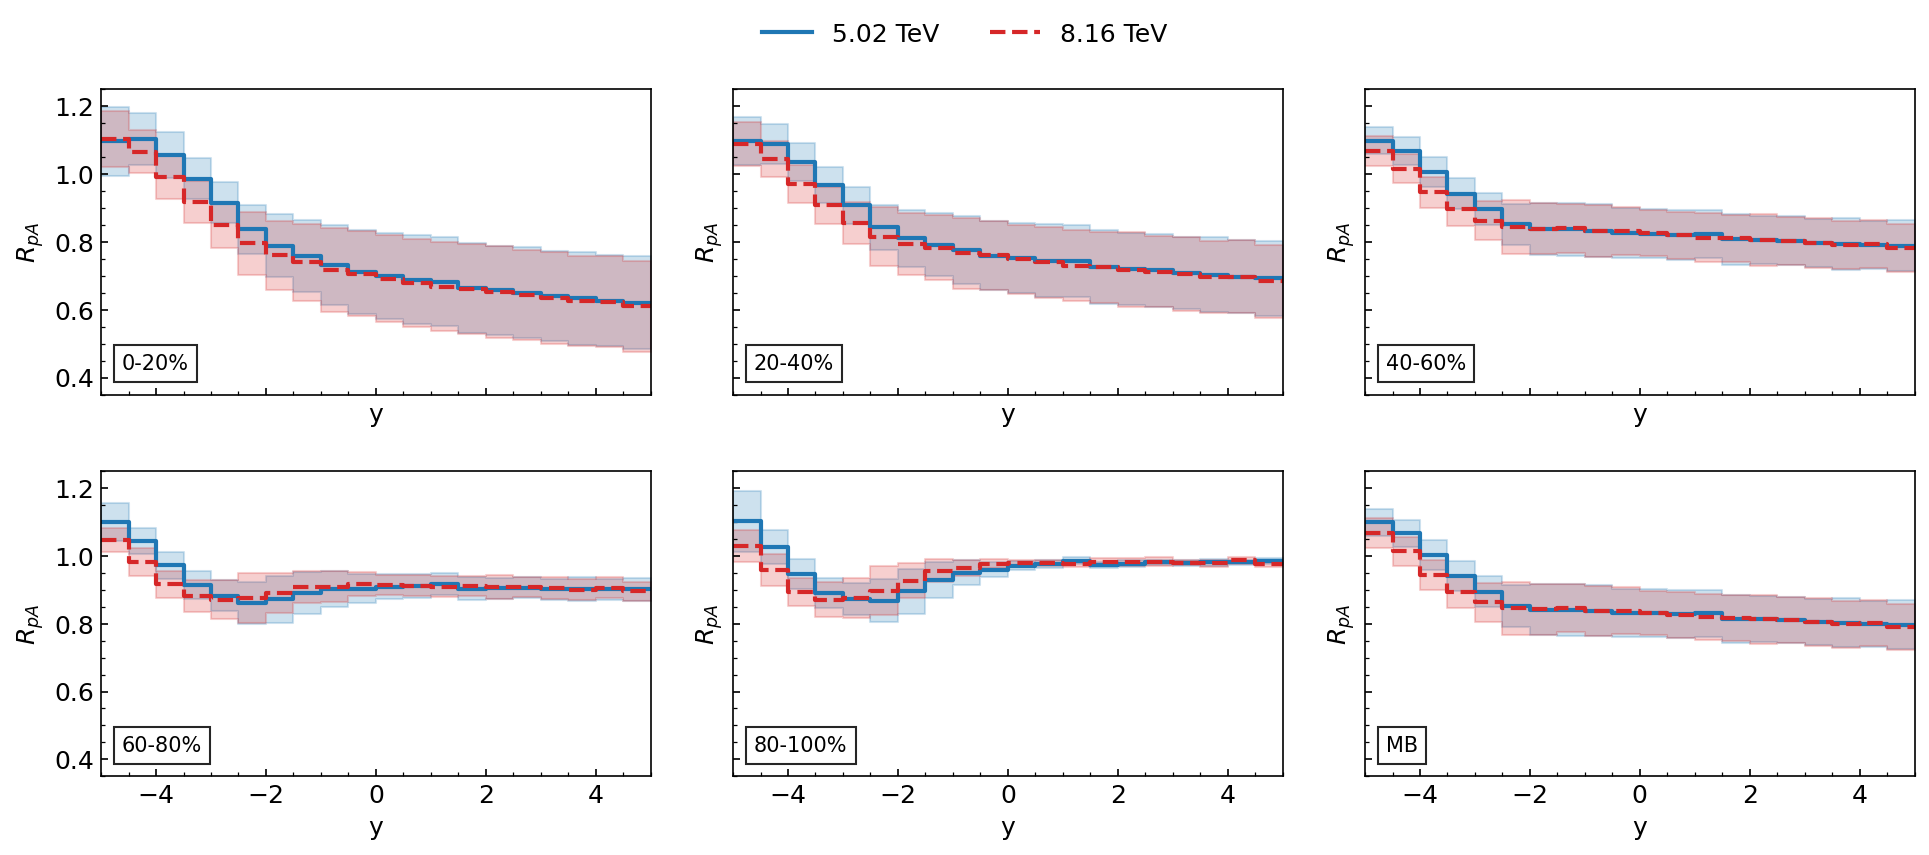

(<Figure size 2340x870 with 6 Axes>,
 array([<Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>,
        <Axes: xlabel='y', ylabel='$R_{pA}$'>], dtype=object))

In [ ]:

# (C) Turn off the tweak entirely (exact original behavior):
plot_rpa_vs_y_panels_pub(periph_sanitize=False)

## $R_{pA}$ vs $p_T$

In [ ]:
## Rpa vs pT
def plot_rpa_vs_pT_panels_window(y0, y1, name,
                                 *, ncols=3,
                                 ylim=(0.35, 1.25),
                                 save_pdf=SAVE_PDF, save_csv=SAVE_CSV):

    tags_pt = [f"{a}-{b}%" for (a,b) in cent_bins] + ["MB"]
    n_pan   = len(tags_pt)
    n_cols  = ncols
    n_rows  = int(np.ceil(n_pan / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.2*n_cols, 2.9*n_rows),
                             dpi=DPI, sharex=True, sharey=True)
    axes = np.atleast_1d(axes).ravel()

    handles_, labels_ = [], []

    for ip, tag in enumerate(tags_pt):
        ax = axes[ip]

        for ETAG, dfmap, sysX in [("5.02", df49_by_cent_5, sys5),
                                  ("8.16", df49_by_cent_8, sys8)]:

            # pick centrality or MB stack
            if tag != "MB":
                df49 = dfmap[tag].copy(); df49["wcent"] = 1.0
            else:
                rows=[]
                for (a,b) in cent_bins:
                    ctag = f"{a}-{b}%"
                    tmp = dfmap[ctag].copy()
                    tmp["wcent"] = WCENT[ctag]
                    rows.append(tmp)
                df49 = pd.concat(rows, ignore_index=True)

            p_left, r0_band, rlo_band, rhi_band = [], [], [], []
            for pl, pr in zip(P_EDGES[:-1], P_EDGES[1:]):
                sub = df49[(df49["pt"]>=pl) & (df49["pt"]<pr) &
                           (df49["y"]>=y0) & (df49["y"]<=y1)].copy()
                if sub.empty:
                    p_left.append(pl); r0_band.append(np.nan); rlo_band.append(np.nan); rhi_band.append(np.nan); continue

                # NEW: use helper (fixes sysX scoping & keeps logic identical)
                wn = _get_weights(sub, sysX, ETAG)

                r0  = float(np.sum(wn * sub["r_central"].to_numpy()))
                mem = np.array([np.sum(wn * sub[c].to_numpy()) for c in sub.columns if c.startswith("r_mem_")], float)
                D   = mem[0::2] - mem[1::2]
                h   = 0.5*np.sqrt(np.sum(D*D))

                p_left.append(pl); r0_band.append(r0); rlo_band.append(r0-h); rhi_band.append(r0+h)

            x  = np.array(p_left, float)
            xC = np.r_[x, x[-1]+(x[1]-x[0])]
            yC = np.r_[r0_band, r0_band[-1]]
            yL = np.r_[rlo_band, rlo_band[-1]]
            yH = np.r_[rhi_band, rhi_band[-1]]

            ln, = ax.step(xC, yC, where="post", color=COLORS[ETAG], ls=LSTYLE[ETAG], lw=2.0, label=f"{ETAG} TeV")
            ax.fill_between(xC, yL, yH, step="post", color=COLORS[ETAG], alpha=ALPHA_BAND)
            handles_.append(ln); labels_.append(f"{ETAG} TeV")

            if save_csv:
                out = pd.DataFrame(dict(pt_left=x, pt_right=xC[:-1]+(x[1]-x[0]),
                                        r_central=yC[:-1], r_lo=yL[:-1], r_hi=yH[:-1]))
                out.to_csv(OUTDIR/f"data_rpa_vs_pT_{tag.replace('%','pct')}_{name}_{ETAG.replace('.','p')}TeV.csv".replace(' ','_'), index=False)

        beautify_axis(ax, xlabel=r"$p_T$ [GeV]", ylabel=r"$R_{pA}$",
                      xlim=(P_EDGES[0], P_EDGES[-1]), ylim=ylim)
        put_note(ax, tag, loc="upper right")

    # strip empty axes
    for k in range(n_pan, len(axes)):
        fig.delaxes(axes[k])

    # annotate once
    put_note(axes[0], f"{name}", loc="upper left")
    put_note(axes[0], rf"$p_T\in[{PT_RANGE_AVG[0]},\,{PT_RANGE_AVG[1]}]$ GeV", loc="lower left")

    # common legend
    uniq = {}
    for h,l in zip(handles_, labels_): uniq[l] = h
    fig.legend(list(uniq.values()), list(uniq.keys()),
               loc="upper center", ncol=3, frameon=False)

    plt.subplots_adjust(top=0.90, hspace=0.25, wspace=0.15)
    if save_pdf:
        fig.savefig(OUTDIR / f"rpa_vs_pT_panels_{name.replace(' ','_')}_{WEIGHT_MODE}.pdf",
                    bbox_inches="tight")
    plt.show()

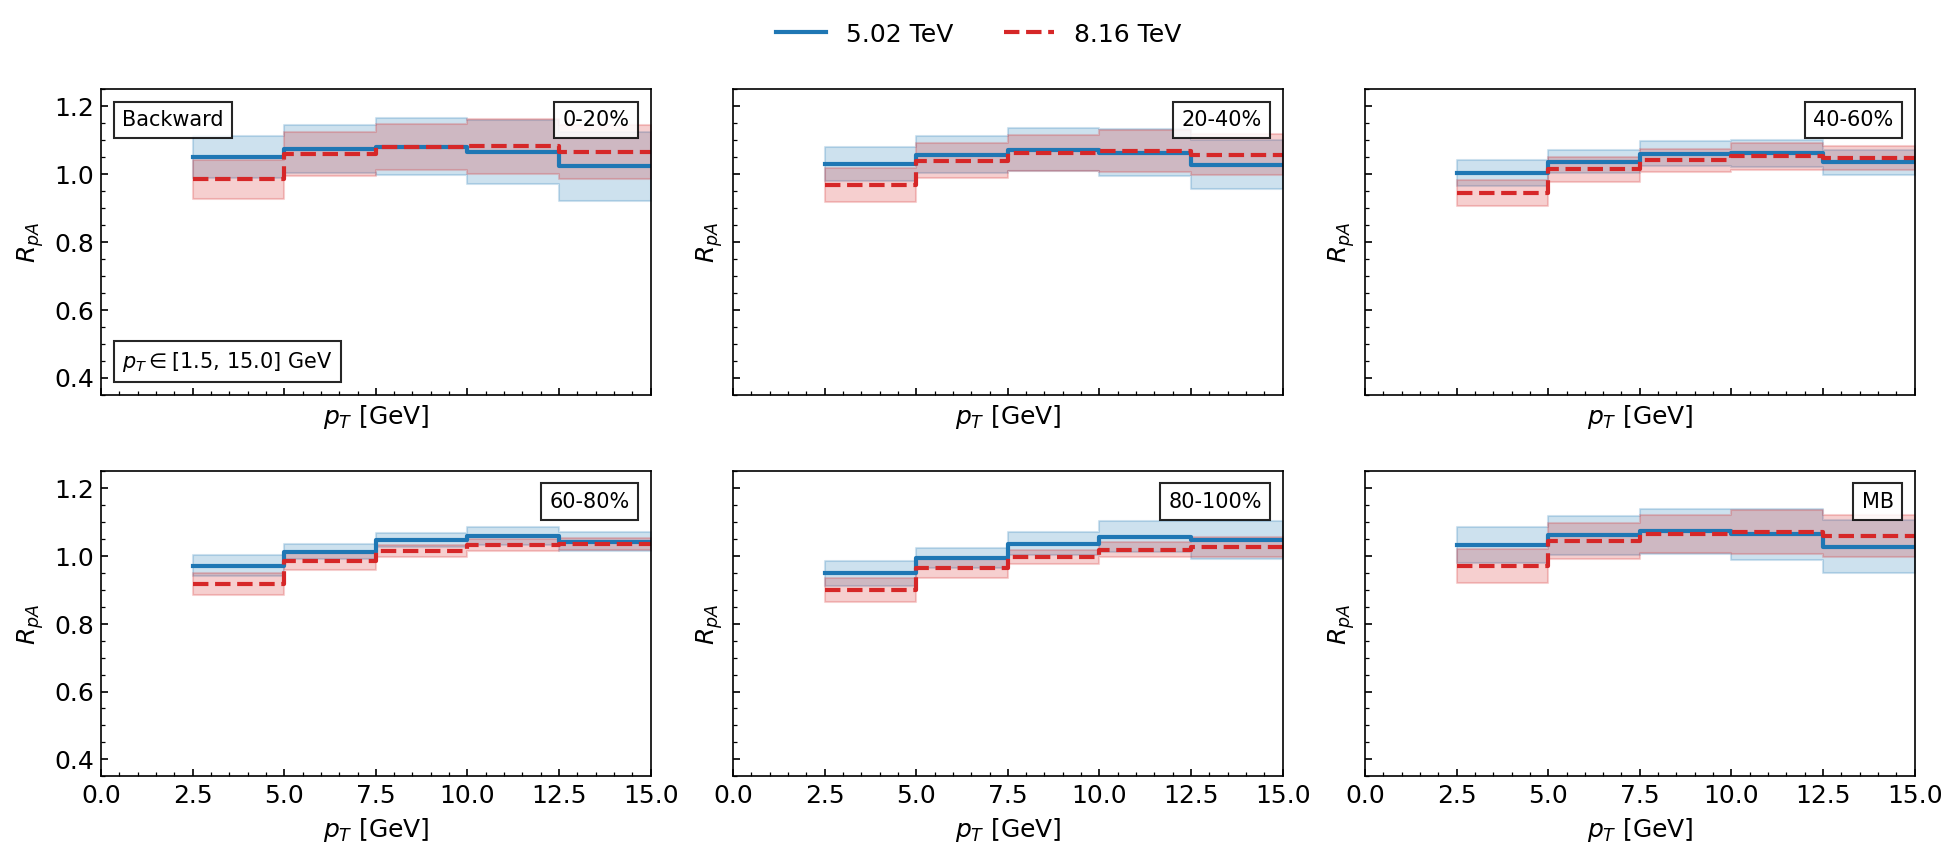

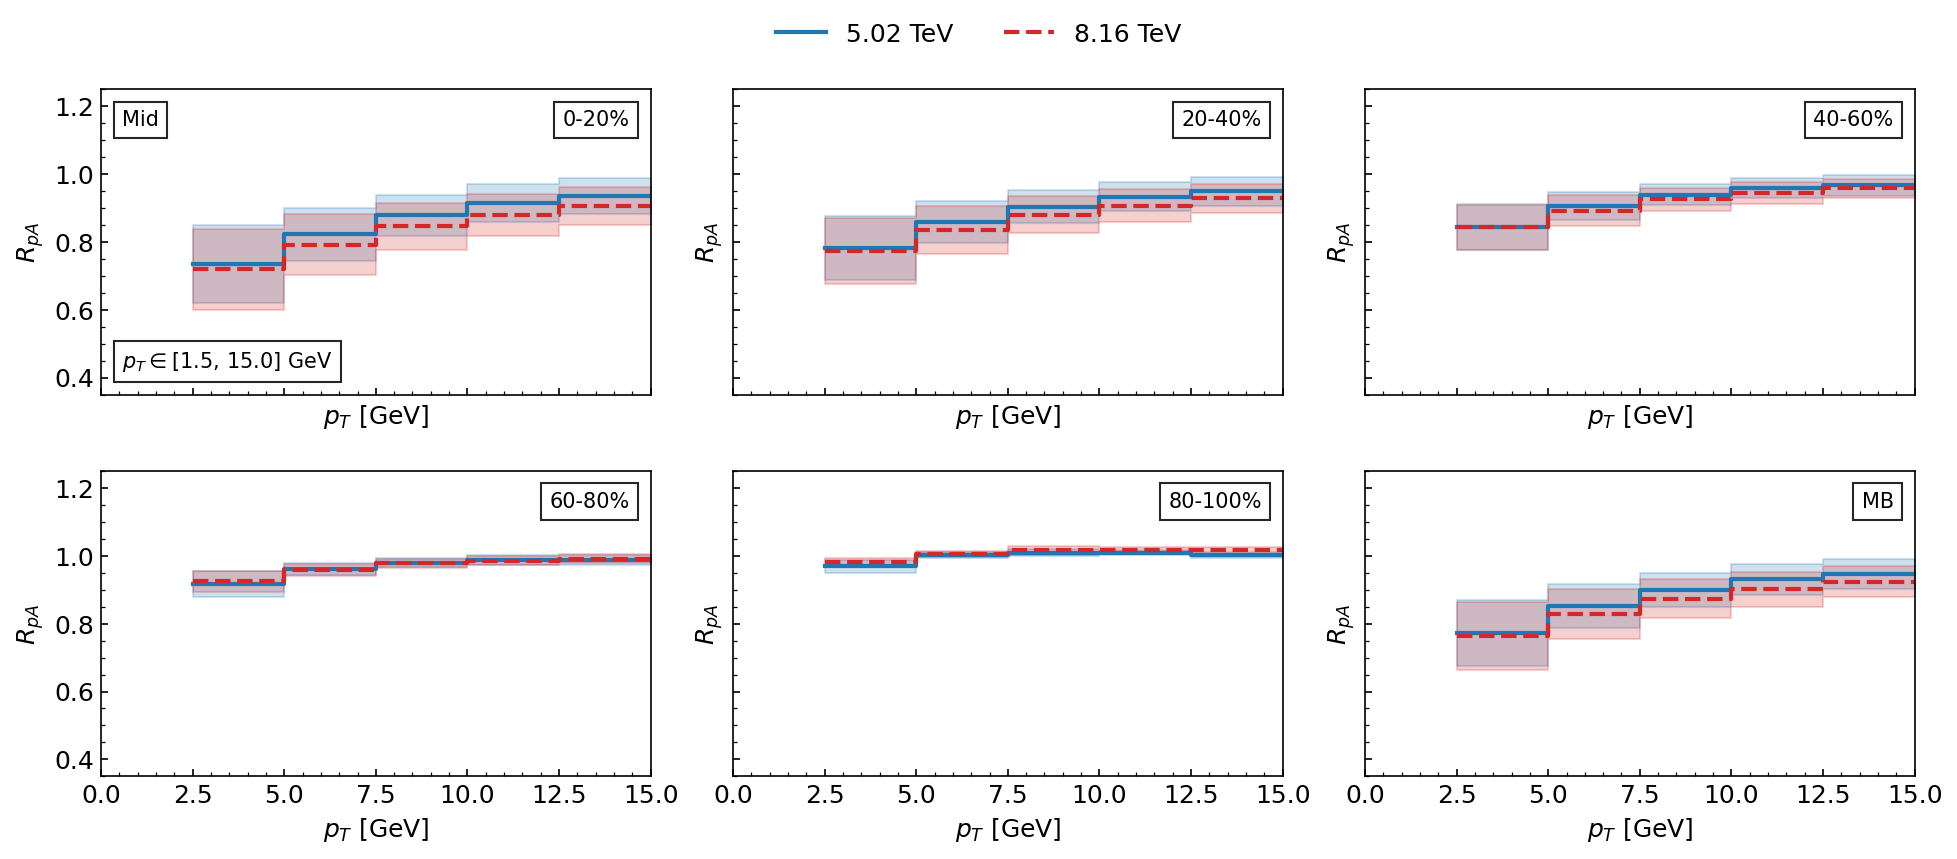

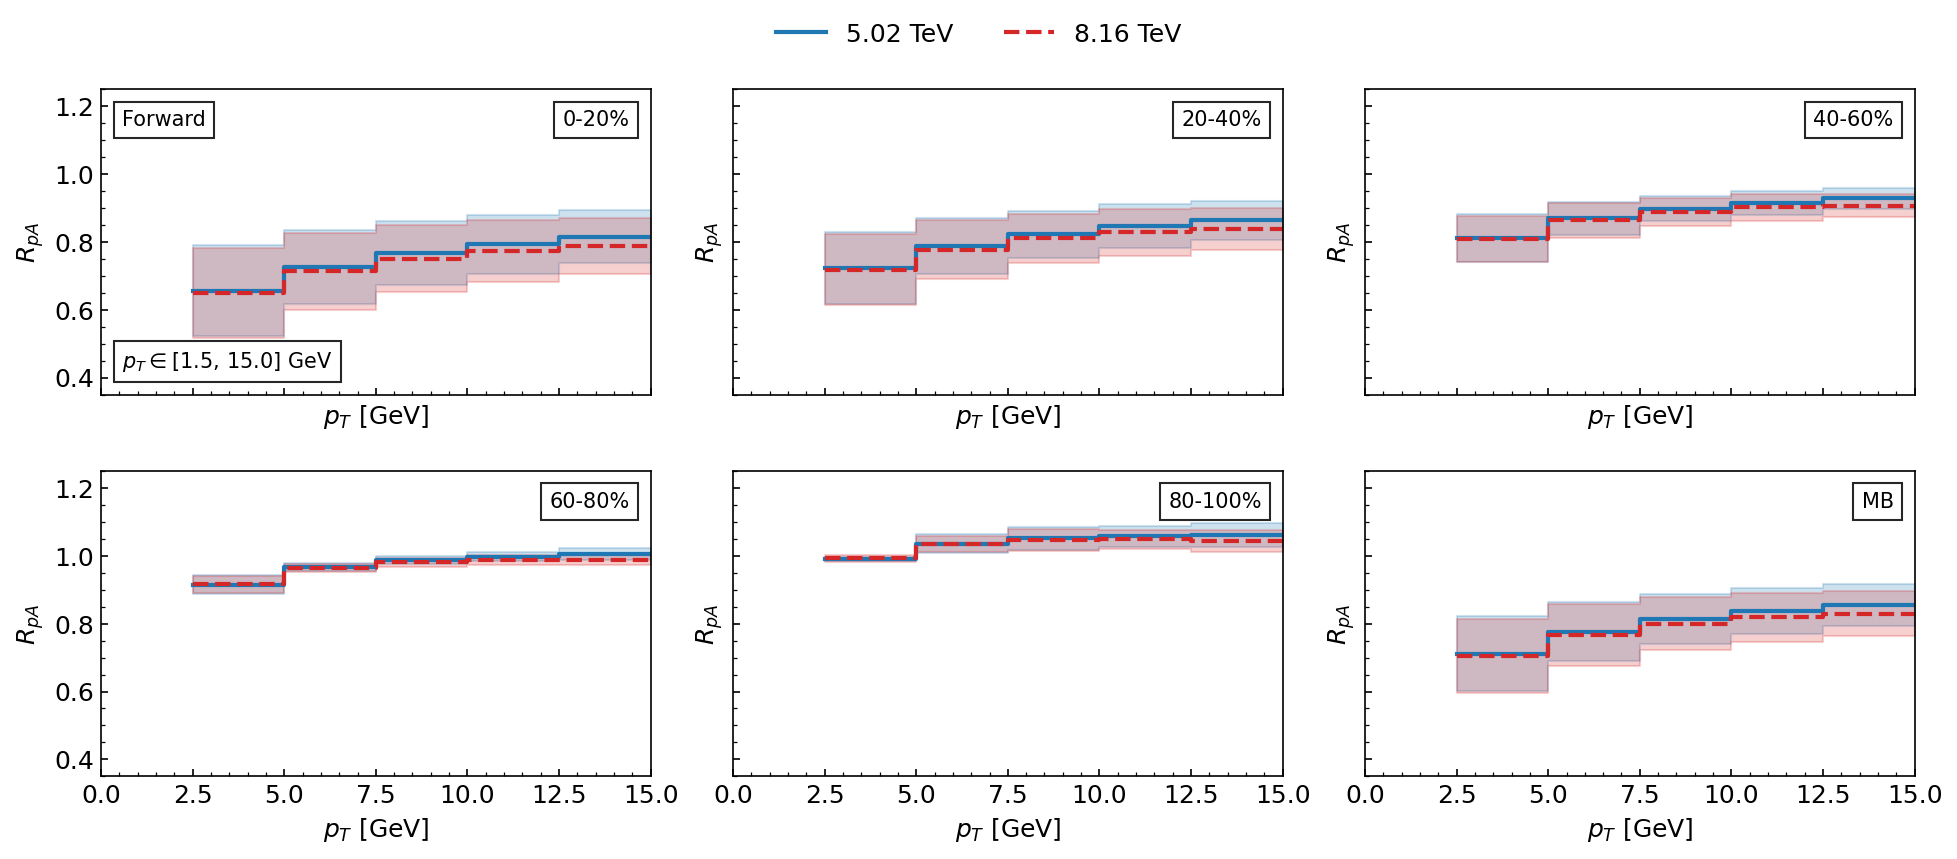

In [ ]:
for (y0, y1, name) in Y_WINDOWS:
    plot_rpa_vs_pT_panels_window(y0, y1, name, ncols=3)

## $R_{pA}$ vs Centrality

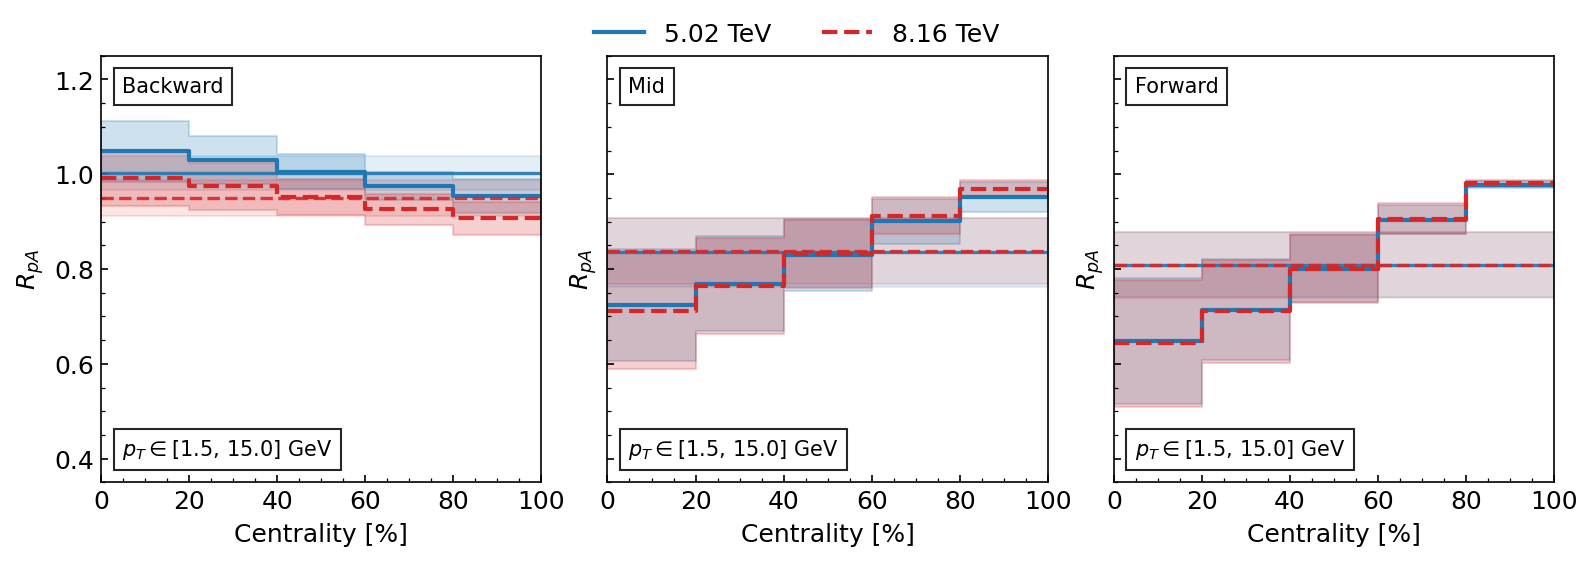

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12.5,3.6), dpi=DPI, sharey=True)
cent_tags = [f"{a}-{b}%" for (a,b) in cent_bins]
cent_left = [a for (a,_) in cent_bins]
wcent     = np.array([(b-a)/100.0 for (a,b) in cent_bins], float)
wcent    /= wcent.sum()

for ax, (y0,y1,name) in zip(axes, Y_WINDOWS):
    handles_, labels_ = [], []

    for ETAG, dfmap, sysX in [("5.02", df49_by_cent_5, sys5), ("8.16", df49_by_cent_8, sys8)]:
        Rc_list, Rlo_list, Rhi_list = [], [], []
        mem_means_by_bin = []  # collect member means per centrality for MB combination

        for tag in cent_tags:
            g = dfmap[tag]
            sub = g[(g["y"]>=y0) & (g["y"]<=y1) &
                    (g["pt"]>=PT_RANGE_AVG[0]) & (g["pt"]<=PT_RANGE_AVG[1])].copy()
            if sub.empty:
                Rc_list.append(np.nan); Rlo_list.append(np.nan); Rhi_list.append(np.nan)
                mem_means_by_bin.append(np.full(48, np.nan))
                continue

            # weights (same, no change)
            mode = WEIGHT_MODE
            if mode == "flat":
                w = np.ones(len(sub), float)
            elif mode == "pa@y0":
                lut={}
                for ptv, grp in sysX.df_pa.groupby("pt"):
                    ys=grp["y"].to_numpy(); vals=grp["val"].to_numpy()
                    j=int(np.argmin(np.abs(ys - Y_REF))); lut[float(ptv)]=float(vals[j])
                w=sub["pt"].map(lambda v: lut.get(float(v),0.0)).to_numpy()
            elif mode == "pa@local":
                lut={(float(r.y),float(r.pt)):float(r.val) for r in sysX.df_pa.itertuples()}
                w=np.array([lut.get((float(r.y),float(r.pt)),0.0) for r in sub.itertuples()], float)
            elif mode == "pp@local":
                lut={(float(r.y),float(r.pt)):float(r.val) for r in sysX.df_pp.itertuples()}
                w=np.array([lut.get((float(r.y),float(r.pt)),0.0) for r in sub.itertuples()], float)
            elif mode == "SA@y0":
                puniq=np.sort(sub["pt"].unique())
                gprov=epps5 if ETAG=="5.02" else epps8
                SAref=gprov.SA_ypt_set(np.full_like(puniq,Y_REF), puniq, set_id=1)
                lut={float(p):float(v) for p,v in zip(puniq, SAref)}
                w=sub["pt"].map(lambda v: lut.get(float(v),0.0)).to_numpy()
            else:
                raise ValueError

            if PT_FLOOR_W is not None and mode not in ("flat","SA@y0"):
                mask_bad=(sub["pt"].to_numpy()<float(PT_FLOOR_W))
                if Y_GUARD_MAX is not None:
                    mask_bad &= (sub["y"].to_numpy() <= float(Y_GUARD_MAX))
                if np.any(mask_bad):
                    src=sysX.df_pa if mode.startswith("pa@") else sysX.df_pp
                    for yy in np.unique(sub.loc[mask_bad,"y"].to_numpy()):
                        cand=src[(src["y"]==float(yy))&(src["pt"]>=float(PT_FLOOR_W))].sort_values("pt")
                        if len(cand):
                            w[(sub["y"].to_numpy()==yy)&mask_bad] = float(cand["val"].iloc[0])
            if (WINSOR is not None) and np.any(w>0):
                cap=float(WINSOR[1])*np.nanquantile(w[w>0], float(WINSOR[0]))
                w=np.clip(w,0.0,cap)

            wn = (w/np.sum(w)) if np.sum(w)>0 else np.ones_like(w)/len(w)

            r0  = np.sum(wn * sub["r_central"].to_numpy())
            mem = np.array([np.sum(wn * sub[c].to_numpy()) for c in sub.columns if c.startswith("r_mem_")], float)
            D   = mem[0::2] - mem[1::2]
            h   = 0.5*np.sqrt(np.sum(D*D))

            Rc_list.append(r0); Rlo_list.append(r0-h); Rhi_list.append(r0+h)
            mem_means_by_bin.append(mem)

        # draw step bands for centrality bins
        c   = np.array(cent_left, float)
        xC  = np.r_[c, 100.0]
        yC  = np.r_[Rc_list, Rc_list[-1]]
        yL  = np.r_[Rlo_list, Rlo_list[-1]]
        yH  = np.r_[Rhi_list, Rhi_list[-1]]

        ln, = ax.step(xC, yC, where="post", color=COLORS[ETAG], ls=LSTYLE[ETAG], lw=2.0, label=f"{ETAG} TeV")
        ax.fill_between(xC, yL, yH, step="post", color=COLORS[ETAG], alpha=ALPHA_BAND)
        handles_.append(ln); labels_.append(f"{ETAG} TeV")

        # --- accurate MB (central + member means weighted by bin width)
        mem_means_by_bin = np.array(mem_means_by_bin, float)  # (nbin, 48)
        with np.errstate(invalid='ignore'):
            mem_mb = np.nansum(wcent[:,None] * mem_means_by_bin, axis=0)
        Dmb = mem_mb[0::2] - mem_mb[1::2]
        hmb = 0.5*np.sqrt(np.sum(Dmb*Dmb))
        rmb = float(np.nansum(wcent * np.array(Rc_list, float)))
        ax.hlines([rmb], 0, 100, colors=COLORS[ETAG], linestyles=LSTYLE[ETAG], lw=1.6, alpha=0.9)
        ax.fill_between([0,100], [rmb-hmb, rmb-hmb], [rmb+hmb, rmb+hmb], color=COLORS[ETAG], alpha=0.12)

        if SAVE_CSV:
            out = pd.DataFrame(dict(cent_left=c, r_central=Rc_list, r_lo=Rlo_list, r_hi=Rhi_list))
            out.to_csv(OUTDIR/f"data_rpa_vs_centrality_{name}_{ETAG.replace('.','p')}TeV.csv".replace(' ','_'), index=False)

    beautify_axis(ax, xlabel="Centrality [%]", ylabel=r"$R_{pA}$",
                  xlim=(0,100), ylim=(0.35,1.25))
    # put y-window and pT-range as notes (no titles)
    put_note(ax, name, loc="upper left")
    put_note(ax, rf"$p_T\in[{PT_RANGE_AVG[0]},\,{PT_RANGE_AVG[1]}]$ GeV", loc="lower left")

# single legend
uniq = {}
for h,l in zip(handles_, labels_): uniq[l]=h
fig.legend(list(uniq.values()), list(uniq.keys()), loc="upper center", ncol=2, frameon=False)

plt.subplots_adjust(top=0.90, wspace=0.15)
if SAVE_PDF:
    fig.savefig(OUTDIR/f"rpa_vs_centrality_{WEIGHT_MODE}.pdf", bbox_inches="tight")
plt.show()
